# Nanopore long-read sequencing uncovers hundreds of structural variants in the Schistosome genome
*Shalini Nair, Elisha Enabulele, Xue Li, Tim Anderson, Neal Platt*

__ABSTRACT__: Nanopore sequencing generates extremely long sequence reads allowing detailed characterization of genomic features (genome rearrangements/structural variants) that are difficult to accurately assay using Illumina short-read sequencing approaches. Technological improvements in Nanopore long-read sequence have resulted in reduced prices, as well as increased accuracy and output. This method was declared “Method of the year” in Nature in 2022. Our laboratory is exploring the use of nanopore for characterizing pathogen genomes. Here, we detail application of nanopore sequencing of schistosome parasites. These parasites have a 380 Mb genome that is riddled with repetitive elements and structural variants. We have developed protocols that allow generation of reads up to 200kb, with 50% of reads > 24kb, and generation of 13.5 Gb of high-quality data from a single R10 flow cell, providing 27x coverage of the parasite genome.  Using this new data, we have identified multiple structural variants segregating in a lab strain of S. mansoni that would not have been visible using short read sequencing alone.  For example, we have found 468 large structural variants (>500bp) that were completely fixed in our laboratory population compared to the reference genome/strain. We anticipate that characterization of large structural variants may help to identify causative features underlying important schistosome phenotypes. Nanopore also has many possible uses for other researchers at Texas biomed, including sequencing entire viral genomes or host MHC, and rapid monitoring of infectious diseases in global populations.

**[08/04/2023] Nanopore analysis ideas**

- Are the genomes of lab populations syntenic or have large changes in gene structure/order been introduced?
  - __This would be extremely interesting__
  - Aside – one possible explanation for the division between Sh populations might be rearrangements/inversions
- What impact do large SVs have on the coding regions of the genome?
  - Comment – define impact here. It would certainly be interesting to know whether SVs in coding sequences seem likely to reduce/eliminate gene expression
- Is there evidence of population specific SVs (including CNVs/gene family expansions/contractions)?
- Can we recover and examine variability in complex regions like SmPoMucs and how is this variability distributed among and within lab populations?
  - __Yes – v important.__
  - Simply identifying the genome location of these genes will be very important – we would like to be able to definitively state that smPoMucs do/do not colocalize with the host specificity QTLs that Fred has mapped.
- Are there large SVs in important regions associated with parasite phenotypes?
  - Important question but difficult to do. I think we can certainly examine how many SVs are segregating in QTL regions, to highlight possible causative SVs
- (Some interesting question about the tandem repeat region in the mitochondrial genome...not sure what yet)
  - There is some old literature about these regions, suggesting v rapid change and extensive polymorphism within individuals. This might be difficult with the population data, but would be great to do when we have data from individual genotypes. Perhaps worth waiting until we have that data.
- __Is it possible to identify SVs that are being selected (for/against)?__
  - I think this is particularly interesting. We expect most SVs to be selected against.
  - Comparing allele frequencies within populations would be informative – we expect most to be at low frequency. High frequency SVs are good candidates for positive selection
  - __Comparing SV burden in coding vs non-coding regions would be informative to understand strength of selection against SVs__
  - __Likewise, comparing SVs in low and high recombination rate regions. We predict higher frequency/larger SVs in high recombination regions__

# Preping for structural variants

## Prep analyses

In [1]:
import io
import os
from collections import defaultdict
from itertools import combinations
from pathlib import Path

import gffutils
import numpy as np
import pandas as pd
import vcf
import venn
from Bio import SeqIO
from intervaltree import IntervalTree
from matplotlib import pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from tqdm import tqdm

In [2]:
proj_dir = "/master/nplatt/sch_man_ont"
ref_fas = "{}/data/genome/SM_V10.fa".format(proj_dir)
Path("{}/results".format(proj_dir)).mkdir(parents=True, exist_ok=True)

In [3]:
samples = ["smbre", "smeg", "smle-pzq-er", "smle-pzq-es", "smor"]
pops = samples

In [4]:
os.chdir("{}/results".format(proj_dir))

# Raw Long Reads

The raw data is from multiple sequencing runs and it is best/easisest if we combine it into a single file for downstream work.

In [5]:
Path("{}/results/raw_reads".format(proj_dir)).mkdir(parents=True, exist_ok=True)
os.chdir("{}/results/raw_reads".format(proj_dir))

In [ ]:
%%bash 

DATA=/master/nplatt/sch_man_ont/data

# smbre ----------------------
zcat $DATA/SmBRE_10182022/no_sample/20221018_1043_MC-110254_FAT94061_3be94c01/fastq_pass/FAT94061_pass_5e6aef65_*gz >smbre.fastq &
# ----------------------------

# smeg -----------------------
zcat $DATA/SmEG_2/no_sample/20221219_1251_MC-110254_FAV14922_3a8a2fa9/fastq_pass/FAV14922_pass_24ea1607_*gz \
     $DATA/SmEG_Female_6_02_22/no_sample/20220523_1102_MC-110254_FAT13494_c562973b/fastq_pass/FAT13494_pass_5a70f0ff_*.gz\
     >smeg.fastq &
#-----------------------------

# smle-pzq-er ----------------
zcat $DATA/V14_Smle_R/no_sample/20230105_1829_MC-110254_FAU92303_cc3e8354/fastq_pass/FAU92303_pass_cc3e8354_368dd688_*gz \
    >smle-pzq-er.fastq &
#-----------------------------

# smle-pzq-es ----------------
zcat $DATA/schisto_pairs_04132022/no_sample/20220413_1030_MC-110254_FAS57617_fdc4f280/fastq_pass/FAS57617_pass_f77dcaa6_*gz \
    $DATA/V14_Smle_S/no_sample/20230109_1649_MC-110254_FAV67293_20684beb/fastq_pass/FAV67293_pass_20684beb_b8e64529_*gz \
    $DATA/V14_Smle_S_2/no_sample/20230110_1931_MC-110254_FAV67293_70d56838/fastq_pass/FAV67293_pass_70d56838_f285c3d6_*gz \
    >smle-pzq-es.fastq &
#----------------------------

# smor ----------------------
zcat $DATA/SmOR_Female_5_25_22/no_sample/20220530_1011_MC-110254_FAT30731_19d6f87b/fastq_pass/FAT30731_pass_99b43000_*.gz >smor.fastq &
#----------------------------


# Run snakemake

the `01-gt-svs.snk.py` snake code should take the raw seqeucning reads through filtration, mapping, post-proc, and genotyping. See that file for more info

In [ ]:
# snakemake
#     --printshellcmds
#     --cluster 'qsub -V -cwd -j y -S /bin/bash -pe smp {threads} -q all.q -o {log} '
#     --jobs 200
#     --latency-wait 200
#     --keep-going
#     --rerun-incomplete
#     --snake code/01-gt_svs.snk.py
#     --use-conda
#     --jobname snk.ONT.{name}.jid{jobid}

# Raw Data Table

In [88]:
Path("{}/results/sample_summary_table".format(proj_dir)).mkdir(
    parents=True, exist_ok=True
)
os.chdir("{}/results/sample_summary_table".format(proj_dir))

In [89]:
raw_n50_df = pd.read_csv(f"../raw_reads/n50_raw_reads.csv", header=0, sep=",")
pops = [x.split("/")[6].replace(".fastq", "") for x in raw_n50_df["#path"]]
raw_n50_df["#path"] = pops
raw_n50_df = raw_n50_df.rename({"#path": "pop"}, axis=1)
cols = [f"{x}.raw" for x in raw_n50_df.columns]
raw_n50_df.columns = cols
raw_n50_df

,pop.raw,seqs.raw,size.raw,N50.raw,min.raw,max.raw,N75.raw,N90.raw,auN.raw
0,smbre,2757714,14071249606,15795,94,193119,7163,2248,370049.65
1,smeg,1696681,9490830960,13449,86,236992,6098,2704,276864.56
2,smle-pzq-es,3982589,22914921839,13044,33,198255,5555,2471,624451.87
3,smle-pzq-er,1707939,7212860476,11608,13,447404,4577,1795,237404.00
4,smor,4277708,14622901611,8232,92,168323,3171,1394,626721.58


In [90]:
filt_n50_df = pd.read_csv(f"../nanoq/n50_filtered_reads.csv", header=0, sep=",")
pops = [x.split("/")[6].replace(".nanoq.fastq", "") for x in filt_n50_df["#path"]]
filt_n50_df["#path"] = pops
filt_n50_df = filt_n50_df.rename({"#path": "pop"}, axis=1)
cols = [f"{x}.filt" for x in filt_n50_df.columns]
filt_n50_df.columns = cols
filt_n50_df

,pop.filt,seqs.filt,size.filt,N50.filt,min.filt,max.filt,N75.filt,N90.filt,auN.filt
0,smbre,2156891,13733527914,16145,500,193069,7657,2728,357349.74
1,smeg,1397888,9315645341,13681,500,236942,6337,2921,273369.67
2,smle-pzq-es,3558751,22574090671,13259,500,198205,5706,2592,615206.75
3,smle-pzq-er,1330051,7000372416,12071,500,447354,4953,2105,227185.13
4,smor,3413369,14119478724,8668,500,168273,3430,1618,598308.11


In [91]:
num_df = pd.merge(raw_n50_df, filt_n50_df, left_on="pop.raw", right_on="pop.filt")
num_df = num_df.rename({"pop.raw": "pop"}, axis=1)
num_df.drop("pop.filt", axis=1, inplace=True)
num_df

,pop,seqs.raw,size.raw,N50.raw,min.raw,max.raw,N75.raw,N90.raw,auN.raw,seqs.filt,size.filt,N50.filt,min.filt,max.filt,N75.filt,N90.filt,auN.filt
0,smbre,2757714,14071249606,15795,94,193119,7163,2248,370049.65,2156891,13733527914,16145,500,193069,7657,2728,357349.74
1,smeg,1696681,9490830960,13449,86,236992,6098,2704,276864.56,1397888,9315645341,13681,500,236942,6337,2921,273369.67
2,smle-pzq-es,3982589,22914921839,13044,33,198255,5555,2471,624451.87,3558751,22574090671,13259,500,198205,5706,2592,615206.75
3,smle-pzq-er,1707939,7212860476,11608,13,447404,4577,1795,237404.00,1330051,7000372416,12071,500,447354,4953,2105,227185.13
4,smor,4277708,14622901611,8232,92,168323,3171,1394,626721.58,3413369,14119478724,8668,500,168273,3430,1618,598308.11


In [92]:
cov_df = pd.read_csv("../mosdepth/covs.cvs", header=0, sep=",")
pops = [x.split("/")[6] for x in cov_df["sample"]]
cov_df["sample"] = pops
cov_df = cov_df.rename({"sample": "pop"}, axis=1)
cov_df.drop(["length", "min"], axis=1, inplace=True)

cov_df

,pop,bases,mean,max
0,smbre,12929852060,33.03,50203
1,smeg,8667206488,22.14,34244
2,smle-pzq-er,6624855708,16.93,10415
3,smle-pzq-es,19947686816,50.96,41164
4,smor,12178116550,31.11,79935


In [93]:
num_df = pd.merge(num_df, cov_df, on="pop")
num_df

,pop,seqs.raw,size.raw,N50.raw,min.raw,max.raw,N75.raw,N90.raw,auN.raw,seqs.filt,size.filt,N50.filt,min.filt,max.filt,N75.filt,N90.filt,auN.filt,bases,mean,max
0,smbre,2757714,14071249606,15795,94,193119,7163,2248,370049.65,2156891,13733527914,16145,500,193069,7657,2728,357349.74,12929852060,33.03,50203
1,smeg,1696681,9490830960,13449,86,236992,6098,2704,276864.56,1397888,9315645341,13681,500,236942,6337,2921,273369.67,8667206488,22.14,34244
2,smle-pzq-es,3982589,22914921839,13044,33,198255,5555,2471,624451.87,3558751,22574090671,13259,500,198205,5706,2592,615206.75,19947686816,50.96,41164
3,smle-pzq-er,1707939,7212860476,11608,13,447404,4577,1795,237404.00,1330051,7000372416,12071,500,447354,4953,2105,227185.13,6624855708,16.93,10415
4,smor,4277708,14622901611,8232,92,168323,3171,1394,626721.58,3413369,14119478724,8668,500,168273,3430,1618,598308.11,12178116550,31.11,79935


In [94]:
%%bash
cd ../minimap2/

echo pop,n_map,rate >mapping_rate.csv
grep "mapped" *.flagstats.txt | grep -v mate | grep -v primary | sed 's/:/,/' | cut -f1,5 -d" " | sed 's/ (/,/' | sed 's/.flagstats.txt//' >>mapping_rate.csv

In [95]:
map_df = pd.read_csv("../minimap2/mapping_rate.csv", header=0, sep=",")
map_df

,pop,n_map,rate
0,smbre,4609342,97.96%
1,smeg,2750312,98.25%
2,smle-pzq-er,2504219,97.52%
3,smle-pzq-es,6379565,93.52%
4,smor,5904396,90.33%


In [96]:
num_df = pd.merge(num_df, map_df, on="pop")
num_df

,pop,seqs.raw,size.raw,N50.raw,min.raw,max.raw,N75.raw,N90.raw,auN.raw,seqs.filt,...,min.filt,max.filt,N75.filt,N90.filt,auN.filt,bases,mean,max,n_map,rate
0,smbre,2757714,14071249606,15795,94,193119,7163,2248,370049.65,2156891,...,500,193069,7657,2728,357349.74,12929852060,33.03,50203,4609342,97.96%
1,smeg,1696681,9490830960,13449,86,236992,6098,2704,276864.56,1397888,...,500,236942,6337,2921,273369.67,8667206488,22.14,34244,2750312,98.25%
2,smle-pzq-es,3982589,22914921839,13044,33,198255,5555,2471,624451.87,3558751,...,500,198205,5706,2592,615206.75,19947686816,50.96,41164,6379565,93.52%
3,smle-pzq-er,1707939,7212860476,11608,13,447404,4577,1795,237404.00,1330051,...,500,447354,4953,2105,227185.13,6624855708,16.93,10415,2504219,97.52%
4,smor,4277708,14622901611,8232,92,168323,3171,1394,626721.58,3413369,...,500,168273,3430,1618,598308.11,12178116550,31.11,79935,5904396,90.33%


In [97]:
%%bash

cd ../cutesv/
echo pop,raw_svs_calls,filt_sv_calls >n_sv_calls.csv

for POP in smbre smeg smle-pzq-er smle-pzq-es smor; do
    RAW=$(grep -v "#" $POP.cutesv.vcf | wc -l)
    FILT=$(grep -v "#" $POP.cutesv.filtered.vcf | wc -l)
    echo $POP,$RAW,$FILT >>n_sv_calls.csv 
done 

In [98]:
n_sv_df = pd.read_csv("../cutesv/n_sv_calls.csv", header=0, sep=",")
num_df = pd.merge(num_df, n_sv_df, on="pop")
num_df

,pop,seqs.raw,size.raw,N50.raw,min.raw,max.raw,N75.raw,N90.raw,auN.raw,seqs.filt,...,N75.filt,N90.filt,auN.filt,bases,mean,max,n_map,rate,raw_svs_calls,filt_sv_calls
0,smbre,2757714,14071249606,15795,94,193119,7163,2248,370049.65,2156891,...,7657,2728,357349.74,12929852060,33.03,50203,4609342,97.96%,34806,15039
1,smeg,1696681,9490830960,13449,86,236992,6098,2704,276864.56,1397888,...,6337,2921,273369.67,8667206488,22.14,34244,2750312,98.25%,23476,6728
2,smle-pzq-es,3982589,22914921839,13044,33,198255,5555,2471,624451.87,3558751,...,5706,2592,615206.75,19947686816,50.96,41164,6379565,93.52%,44036,15921
3,smle-pzq-er,1707939,7212860476,11608,13,447404,4577,1795,237404.00,1330051,...,4953,2105,227185.13,6624855708,16.93,10415,2504219,97.52%,19884,5023
4,smor,4277708,14622901611,8232,92,168323,3171,1394,626721.58,3413369,...,3430,1618,598308.11,12178116550,31.11,79935,5904396,90.33%,31631,13579


In [99]:
safe_df = num_df.copy()

In [100]:
num_df = safe_df.copy()

In [101]:
cols_to_keep = [
    "pop",
    "seqs.filt",
    "size.filt",
    "N50.filt",
    "max.filt",
    "rate",
    "mean",
    "raw_svs_calls",
    "filt_sv_calls",
]

num_df = num_df[cols_to_keep]

col_names = {
    "pop": "Population",
    "seqs.filt": "Num. Filt. Reads (1e6)",
    "size.filt": "Num. Filt. Bases (Gb)",
    "N50.filt": "N50 Filt. Reads (bp)",
    "max.filt": "Max Filt. Read Len. (Kb)",
    "mean": "Mean Genome Cov",
    "rate": "Read Mapping Rate",
    "raw_svs_calls": "Num. Raw SV Calls",
    "filt_sv_calls": "Num. Filt. SV Calls",
}

num_df = num_df.rename(col_names, axis=1)
real_pops = ["SmBre", "SmEG", "SmLE-PZQ-ES", "SmLE-PZQ-ER", "SmOR"]
num_df["Population"] = real_pops

num_df["Num. Filt. Reads (1e6)"] = [
    f"{x/1_000_000:.2f}" for x in num_df["Num. Filt. Reads (1e6)"]
]
num_df["Num. Filt. Bases (Gb)"] = [
    f"{x/1_000_000_000:.2f}" for x in num_df["Num. Filt. Bases (Gb)"]
]
num_df["Max Filt. Read Len. (Kb)"] = [
    f"{x/1_000:.2f}" for x in num_df["Max Filt. Read Len. (Kb)"]
]


num_df

,Population,Num. Filt. Reads (1e6),Num. Filt. Bases (Gb),N50 Filt. Reads (bp),Max Filt. Read Len. (Kb),Read Mapping Rate,Mean Genome Cov,Num. Raw SV Calls,Num. Filt. SV Calls
0,SmBre,2.16,13.73,16145,193.07,97.96%,33.03,34806,15039
1,SmEG,1.40,9.32,13681,236.94,98.25%,22.14,23476,6728
2,SmLE-PZQ-ES,3.56,22.57,13259,198.21,93.52%,50.96,44036,15921
3,SmLE-PZQ-ER,1.33,7.00,12071,447.35,97.52%,16.93,19884,5023
4,SmOR,3.41,14.12,8668,168.27,90.33%,31.11,31631,13579


In [ ]:
%%bash
echo sample,longest_mapped>longest_map.csv

for POP in smbre smeg smle-pzq-er smle-pzq-es smor; do
    LONGEST=$(conda run -n samtools samtools view -F 4 ../minimap2/$POP.bam | awk '{print length($10), $1}' | sort -nr | head -1)
    
    echo $POP,$LONGEST>>longest_map.csv 
done 

In [136]:
num_df.to_csv("../figures_and_tables/basic_sequence_stats_per_population.csv", sep=",", header=True, index=False)

In [97]:
# size of sv variants
# grep -v "#" survivor.vcf  | cut -f3 -d";" | cut -f2 -d"=" | sed s'/-//' | awk '{SUM+=$1} END {print SUM}'
(14200651 / 397918904) * 100

3.5687299239243986

In [103]:
num_df = pd.read_csv("../figures_and_tables/basic_sequence_stats_per_population.csv", sep=",", header=0)
num_df.head()

,Population,Num. Filt. Reads (1e6),Num. Filt. Bases (Gb),N50 Filt. Reads (bp),Max Filt. Read Len. (Kb),Read Mapping Rate,Mean Genome Cov,Num. Raw SV Calls,Num. Filt. SV Calls
0,SmBre,2.16,13.73,16145,193.07,97.96%,33.03,34806,15039
1,SmEG,1.40,9.32,13681,236.94,98.25%,22.14,23476,6728
2,SmLE-PZQ-ES,3.56,22.57,13259,198.21,93.52%,50.96,44036,15921
3,SmLE-PZQ-ER,1.33,7.00,12071,447.35,97.52%,16.93,19884,5023
4,SmOR,3.41,14.12,8668,168.27,90.33%,31.11,31631,13579


## Figure COVERAGE VS CALLS

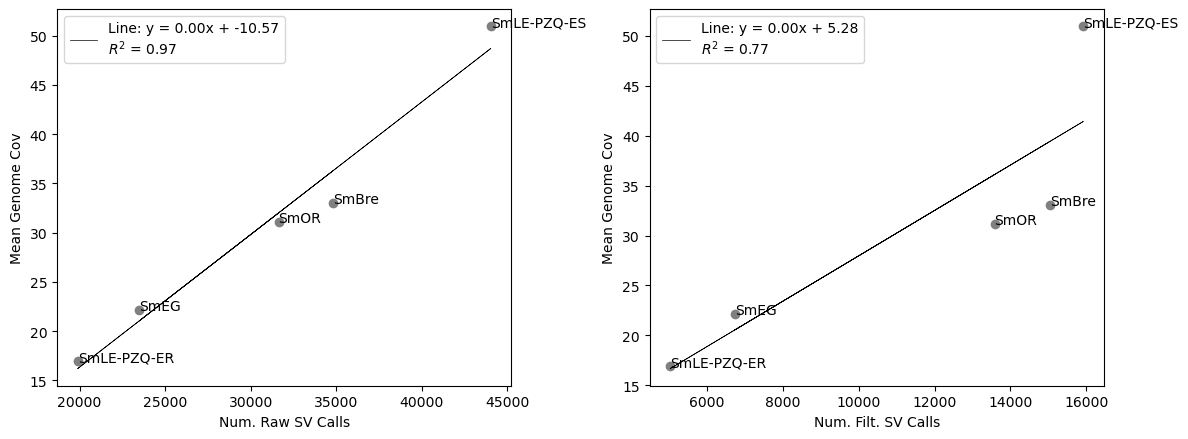

In [135]:
import os
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import linregress

os.chdir("{}/results/sample_summary_table".format(proj_dir))

num_df = pd.read_csv("../figures_and_tables/basic_sequence_stats_per_population.csv", sep=",", header=0)
num_df.head()

# Data for first scatter plot
x1 = num_df["Num. Raw SV Calls"]
y1 = num_df["Mean Genome Cov"]

# Data for second scatter plot
x2 = num_df["Num. Filt. SV Calls"]
y2 = num_df["Mean Genome Cov"]

# Perform linear regression for the first dataset
slope1, intercept1, r_value1, _, _ = linregress(x1, y1)
r2_1 = r_value1**2  # Calculate R^2 for the first regression

# Perform linear regression for the second dataset
slope2, intercept2, r_value2, _, _ = linregress(x2, y2)
r2_2 = r_value2**2  # Calculate R^2 for the second regression

# Plotting the data and the regression lines
fig, axs = plt.subplots(1, 2, figsize=(12, 4.5))

# First scatter plot
axs[0].scatter(x1, y1, color='grey')
# axs[0].set_title("Num. Raw SV Calls vs Mean Genome Cov")
axs[0].set_xlabel("Num. Raw SV Calls")
axs[0].set_ylabel("Mean Genome Cov")

# Add text labels for each point in the first plot
for i in range(num_df.shape[0]):
    axs[0].text(x1.iloc[i], y1.iloc[i], num_df["Population"].iloc[i], size=10)

# Plot regression line for the first dataset
axs[0].plot(x1, slope1 * x1 + intercept1, color='black', linewidth=0.5, label=f'Line: y = {slope1:.2f}x + {intercept1:.2f}\n$R^2$ = {r2_1:.2f}')
axs[0].legend()

# Second scatter plot
axs[1].scatter(x2, y2, color='grey')
# axs[1].set_title("Num. Filt. SV Calls vs Mean Genome Cov")
axs[1].set_xlabel("Num. Filt. SV Calls")
axs[1].set_ylabel("Mean Genome Cov")

# Add text labels for each point in the second plot
for i in range(num_df.shape[0]):
    axs[1].text(x2.iloc[i], y2.iloc[i], num_df["Population"].iloc[i], size=10)

# Plot regression line for the second dataset
axs[1].plot(x2, slope2 * x2 + intercept2, color='black', linewidth=0.5, label=f'Line: y = {slope2:.2f}x + {intercept2:.2f}\n$R^2$ = {r2_2:.2f}')
axs[1].legend()

# Adjust layout to prevent overlap
plt.tight_layout()

# Save plot
plt.savefig("../figures_and_tables/coverage_vs_sv_calls.png", format="png", dpi=600, facecolor="white")
plt.savefig("../figures_and_tables/coverage_vs_sv_calls.svg", facecolor="white")

# Show the plot
plt.show()


# what CUTESV variants were filtered

In [219]:
os.chdir("{}/results/cutesv".format(proj_dir))

In [324]:
import vcf
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# List of your VCF files for different populations
vcf_files = {
    "smbre": "smbre.cutesv.vcf",
    "smeg": "smeg.cutesv.vcf",
    "smle-pzq-er": "smle-pzq-er.cutesv.vcf",
    "smle-pzq-es": "smle-pzq-es.cutesv.vcf",
    "smor": "smor.cutesv.vcf"
}

# Initialize a DataFrame to store all data
combined_df = pd.DataFrame()

# Loop through each population VCF file
for population, vcf_file in vcf_files.items():
    # Read the VCF file
    vcf_reader = vcf.Reader(open(vcf_file, 'r'))
    
    # Initialize lists to store the data for this population
    svtypes = []
    qual_scores = []
    allele_frequencies = []
    gqs = []
    ref_depths = []
    var_depths = []
    
    # Loop through each record in the VCF
    for record in vcf_reader:
        svtypes.append(record.INFO.get('SVTYPE', 'NA'))  # Use 'NA' if SVTYPE is not available
        qual_scores.append(record.QUAL)
        
        # Assuming the allele frequency is stored in the INFO field under 'AF' or similar key
        af = record.INFO.get('AF', [None])[0]
        allele_frequencies.append(af)

        # Extract GQ, DR (reference depth), and DV (variant depth) from the first sample
        if len(record.samples) > 0:
            sample = record.samples[0]
            gq = sample['GQ']
            dr = sample['DR']  # Reference depth
            dv = sample['DV']  # Variant depth

            gqs.append(gq)
            ref_depths.append(dr)
            var_depths.append(dv)
        else:
            gqs.append(None)
            ref_depths.append(None)
            var_depths.append(None)
    
    # Create a DataFrame from the extracted data
    df = pd.DataFrame({
        'svtype': svtypes,
        'QUAL': qual_scores,
        'Allele Frequency': allele_frequencies,
        'GQ': gqs,
        'Ref Depth': ref_depths,
        'Var Depth': var_depths
    })
    
    # Drop rows where Allele Frequency or GQ is None (if any)
    df = df.dropna(subset=['Allele Frequency', 'GQ'])
    
    # Add a column for population
    df['Population'] = population
    
    # Append the data to the combined DataFrame
    combined_df = pd.concat([combined_df, df], ignore_index=True)

# Display the combined DataFrame
combined_df.head()  # Display the first few rows of the combined DataFrame

,svtype,QUAL,Allele Frequency,GQ,Ref Depth,Var Depth,Population
0,INS,24.1,0.4615,23.0,7.0,6,smbre
1,INS,43.0,0.7000,4.0,3.0,7,smbre
2,DEL,0.1,0.1923,18.0,21.0,5,smbre
3,INS,267.2,0.9118,58.0,3.0,31,smbre
4,INS,0.1,0.2222,15.0,28.0,8,smbre


In [325]:
combined_df["DP"] = combined_df["Ref Depth"] + combined_df["Var Depth"]

In [326]:
# Assuming 'df' is your DataFrame and contains the columns 'Allele Frequency' and 'GQ'

# Bin the allele frequencies
bins = [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]
combined_df['AF_Bin'] = pd.cut(combined_df['Allele Frequency'], bins=bins)
combined_df

,svtype,QUAL,Allele Frequency,GQ,Ref Depth,Var Depth,Population,DP,AF_Bin
0,INS,24.1,0.4615,23.0,7.0,6,smbre,13.0,"(0.4, 0.5]"
1,INS,43.0,0.7000,4.0,3.0,7,smbre,10.0,"(0.6, 0.7]"
2,DEL,0.1,0.1923,18.0,21.0,5,smbre,26.0,"(0.1, 0.2]"
3,INS,267.2,0.9118,58.0,3.0,31,smbre,34.0,"(0.9, 1.0]"
4,INS,0.1,0.2222,15.0,28.0,8,smbre,36.0,"(0.2, 0.3]"
...,...,...,...,...,...,...,...,...,...
153814,DEL,66.4,0.4222,66.0,26.0,19,smor,45.0,"(0.4, 0.5]"
153815,DEL,0.3,0.2222,11.0,21.0,6,smor,27.0,"(0.2, 0.3]"
153816,DEL,99.0,0.7273,3.0,6.0,16,smor,22.0,"(0.7, 0.8]"
153817,INS,219.5,0.9259,49.0,2.0,25,smor,27.0,"(0.9, 1.0]"


In [297]:
# Calculate the median GQ for each AF_Bin
median_gq_by_bin = combined_df.groupby('AF_Bin')['GQ'].median().reset_index()

# Display the resulting table
print(median_gq_by_bin)

       AF_Bin     GQ
0  (0.0, 0.1]  103.0
1  (0.1, 0.2]   45.0
2  (0.2, 0.3]    7.0
3  (0.3, 0.4]   19.0
4  (0.4, 0.5]   39.0
5  (0.5, 0.6]   37.0
6  (0.6, 0.7]   16.0
7  (0.7, 0.8]    6.0
8  (0.8, 0.9]   26.0
9  (0.9, 1.0]   51.0


/tmp/ipykernel_5996/698509321.py:9: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([f'{int(bin.left*100)}-{int(bin.right*100)}%' for bin in combined_df['AF_Bin'].cat.categories])


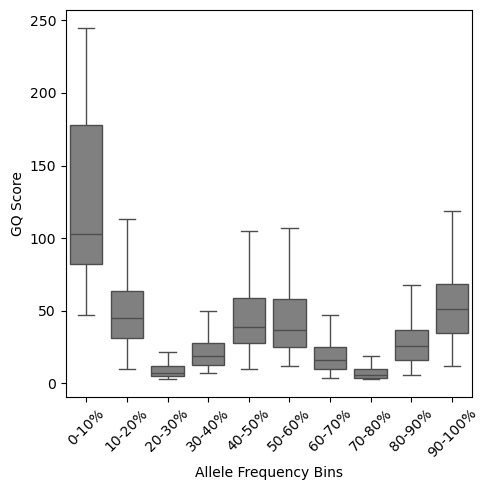

In [300]:
import seaborn as sns
import matplotlib.pyplot as plt

# Create the boxplot without fliers
plt.figure(figsize=(5, 5))
ax = sns.boxplot(x='AF_Bin', y='GQ', data=combined_df, showfliers=False, color="grey")

# Clean up x-axis labels
ax.set_xticklabels([f'{int(bin.left*100)}-{int(bin.right*100)}%' for bin in combined_df['AF_Bin'].cat.categories])

plt.xlabel('Allele Frequency Bins')
plt.ylabel('GQ Score')
# plt.title('GQ Scores Across Allele Frequency Bins')
plt.xticks(rotation=45)
plt.tight_layout()

plt.savefig("../figures_and_tables/gq_vs_af_all_svs.png", format="png", dpi=600, facecolor="white")
plt.savefig("../figures_and_tables/gq_vs_af_all_svs.svg", facecolor="white")


plt.show()


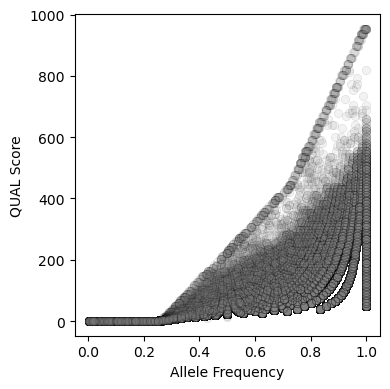

In [301]:
# Plot AF vs QUAL for all populations in grey with alpha
plt.figure(figsize=(4, 4))
sns.scatterplot(
    x='Allele Frequency', 
    y='QUAL', 
    data=combined_df, 
    color='grey',  # All points in grey
    alpha=0.1,  # Transparency for points
    edgecolor="black"
)
plt.xlabel('Allele Frequency')
plt.ylabel('QUAL Score')
plt.tight_layout()

plt.savefig("../figures_and_tables/qual_vs_af_all_svs.png", format="png", dpi=600, facecolor="white")
plt.savefig("../figures_and_tables/qual_vs_af_all_svs.svg", facecolor="white")


plt.show()

In [ ]:
# # Perform linear regression with intercept set to 0
# X = combined_df['Allele Frequency']
# y = combined_df['QUAL']
# X = sm.add_constant(X, has_constant='add')  # Only adds a constant if there isn't one, needed for statsmodels

# # Perform OLS regression without intercept
# model = sm.OLS(y, X[:, 1], hasconst=False).fit()  # X[:, 1] excludes the constant

# # Plot the regression line with intercept 0
# plt.figure(figsize=(10, 6))
# sns.scatterplot(x='Allele Frequency', y='QUAL', data=combined_df, alpha=0.5)
# plt.plot(X[:, 1], model.fittedvalues, color='red', label=f'Fit: y = {model.params[0]:.2f}x')
# plt.xlabel('Allele Frequency')
# plt.ylabel('QUAL Score')
# plt.title('Regression of QUAL Score vs. Allele Frequency with Intercept = 0')
# plt.legend()
# plt.show()

# # Calculate the correlation between QUAL score and Allele Frequency
# correlation, p_value = pearsonr(df['Allele Frequency'], df['QUAL'])
# print(f"Pearson correlation: {correlation:.2f}, P-value: {p_value:.2e}")

In [332]:
combined_df["Population"].value_counts()

Population
smle-pzq-es    44031
smbre          34805
smor           31624
smeg           23475
smle-pzq-er    19884
Name: count, dtype: int64

In [335]:
combined_df.loc[combined_df["DP"] < 10, "Population"].value_counts()

Population
smle-pzq-er    2095
smor            876
smbre           801
smeg            799
smle-pzq-es     250
Name: count, dtype: int64

In [342]:
len(combined_df.loc[combined_df["DP"] < 10])

4821

In [336]:
2095/combined_df.loc[combined_df["DP"] < 10, "Population"].value_counts().sum()

0.4345571458203692

In [320]:
len(combined_df.loc[combined_df["QUAL"] < 10])

44844

In [317]:
len(combined_df.loc[combined_df["QUAL"] < 10])/len(combined_df)

0.2915374563610477

In [318]:
combined_df.loc[combined_df["QUAL"] < 10, ["Allele Frequency"]].max()

Allele Frequency    0.3333
dtype: float64

In [319]:
combined_df.loc[combined_df["QUAL"] > 10, ["Allele Frequency"]].min()

Allele Frequency    0.2703
dtype: float64

In [343]:
# List of your VCF files for different populations
vcf_files = {
    "smbre": "smbre.cutesv.filtered.vcf",
    "smeg": "smeg.cutesv.filtered.vcf",
    "smle-pzq-er": "smle-pzq-er.cutesv.filtered.vcf",
    "smle-pzq-es": "smle-pzq-es.cutesv.filtered.vcf",
    "smor": "smor.cutesv.filtered.vcf"
}

# Initialize a DataFrame to store all data
filtered_df = pd.DataFrame()

# Loop through each population VCF file
for population, vcf_file in vcf_files.items():
    # Read the VCF file
    vcf_reader = vcf.Reader(open(vcf_file, 'r'))
    
    # Initialize lists to store the data for this population
    svtypes = []
    qual_scores = []
    allele_frequencies = []
    gqs = []
    ref_depths = []
    var_depths = []
    
    # Loop through each record in the VCF
    for record in vcf_reader:
        svtypes.append(record.INFO.get('SVTYPE', 'NA'))  # Use 'NA' if SVTYPE is not available
        qual_scores.append(record.QUAL)
        
        # Assuming the allele frequency is stored in the INFO field under 'AF' or similar key
        af = record.INFO.get('AF', [None])[0]
        allele_frequencies.append(af)

        # Extract GQ, DR (reference depth), and DV (variant depth) from the first sample
        if len(record.samples) > 0:
            sample = record.samples[0]
            gq = sample['GQ']
            dr = sample['DR']  # Reference depth
            dv = sample['DV']  # Variant depth

            gqs.append(gq)
            ref_depths.append(dr)
            var_depths.append(dv)
        else:
            gqs.append(None)
            ref_depths.append(None)
            var_depths.append(None)
    
    # Create a DataFrame from the extracted data
    df = pd.DataFrame({
        'svtype': svtypes,
        'QUAL': qual_scores,
        'Allele Frequency': allele_frequencies,
        'GQ': gqs,
        'Ref Depth': ref_depths,
        'Var Depth': var_depths
    })
    
    # Drop rows where Allele Frequency or GQ is None (if any)
    df = df.dropna(subset=['Allele Frequency', 'GQ'])
    
    # Add a column for population
    df['Population'] = population
    
    # Append the data to the combined DataFrame
    filtered_df = pd.concat([filtered_df, df], ignore_index=True)

# Display the combined DataFrame
filtered_df

,svtype,QUAL,Allele Frequency,GQ,Ref Depth,Var Depth,Population
0,INS,24.1,0.4615,23,7,6,smbre
1,INS,43.0,0.7000,4,3,7,smbre
2,INS,267.2,0.9118,58,3,31,smbre
3,INS,238.6,1.0000,63,0,25,smbre
4,DEL,39.2,0.8333,6,1,5,smbre
...,...,...,...,...,...,...,...
108970,INS,53.8,0.4286,53,20,15,smor
108971,DEL,32.7,0.3404,32,31,16,smor
108972,DEL,66.4,0.4222,66,26,19,smor
108973,DEL,99.0,0.7273,3,6,16,smor


In [344]:
1-(len(filtered_df)/len(combined_df))

0.2915374563610478

In [350]:
filtered_df["Allele Frequency"].mean()

0.6627926221610462

# Convert SVJEDI VCF to tables

The output of the snake `01-gt-svs.snk.py` are tsv tables from SVJEDI.  Process thos tables here for downstream analyses.

In [353]:
Path("{}/results/process_sv_tables".format(proj_dir)).mkdir(parents=True, exist_ok=True)
os.chdir("{}/results/process_sv_tables".format(proj_dir))

In [102]:
%%bash

for POP in smeg smbre smor smle-pzq-er smle-pzq-es; do
    echo -e "chrom\tpos\tend\tid\tciend\tsvlen\tsvtype\t${POP}.gt\t${POP}.dp\t${POP}.ad\t${POP}.pl" >${POP}.jedi_genotype.tsv
    conda run -n bcftools --cwd . --live-stream bcftools query --format "%CHROM\t%POS\t%END\t%ID\t%CIEND\t%SVLEN\t%SVTYPE\t[%GT\t%DP\t%AD\t%PL]\n" ../svjedi/${POP}.jedi_genotype.vcf >>${POP}.jedi_genotype.tsv
done

[W::bcf_hdr_check_sanity] PL should be declared as Number=G
[W::vcf_parse_info] INFO/END=768690 is smaller than POS at SM_V10_1:959607
[W::bcf_hdr_check_sanity] PL should be declared as Number=G
[W::vcf_parse_info] INFO/END=768690 is smaller than POS at SM_V10_1:959607
[W::bcf_hdr_check_sanity] PL should be declared as Number=G
[W::vcf_parse_info] INFO/END=768690 is smaller than POS at SM_V10_1:959607
[W::bcf_hdr_check_sanity] PL should be declared as Number=G
[W::vcf_parse_info] INFO/END=768690 is smaller than POS at SM_V10_1:959607
[W::bcf_hdr_check_sanity] PL should be declared as Number=G
[W::vcf_parse_info] INFO/END=768690 is smaller than POS at SM_V10_1:959607


In [354]:
eg_df = pd.read_csv("smeg.jedi_genotype.tsv", sep="\t", header=0)
bre_df = pd.read_csv("smbre.jedi_genotype.tsv", sep="\t", header=0)
er_df = pd.read_csv("smle-pzq-er.jedi_genotype.tsv", sep="\t", header=0)
es_df = pd.read_csv("smle-pzq-es.jedi_genotype.tsv", sep="\t", header=0)
or_df = pd.read_csv("smor.jedi_genotype.tsv", sep="\t", header=0)

In [373]:
or_df

,chrom,pos,end,id,ciend,svlen,svtype,smor.gt,smor.dp,smor.ad,smor.pl
0,SM_V10_1,12381,19783898,cuteSV.BND.1,"0,0",0,TRA,./.,0.0,"0,0",".,.,."
1,SM_V10_1,13412,14879,cuteSV.DEL.0,"0,0",-1467,DEL,0/1,244.0,"30,214","8820,350,906"
2,SM_V10_1,13414,19782952,cuteSV.BND.2,"0,0",0,TRA,./.,0.0,"0,0",".,.,."
3,SM_V10_1,14246,14830,cuteSV.DEL.0,"0,0",-584,DEL,0/1,30.0,"4,26","1073,45,127"
4,SM_V10_1,15040,15637,cuteSV.DEL.1,"0,0",-597,DEL,0/1,244.0,"130,114","4183,15,4872"
...,...,...,...,...,...,...,...,...,...,...,...
17560,SM_V10_Z,86680808,86682886,cuteSV.DEL.16745,"0,0",-2078,DEL,0/1,8.5,"5.5,3","109,6,217"
17561,SM_V10_Z,86683524,86683767,cuteSV.DEL.23672,"0,0",-243,DEL,0/1,6.0,"3,3","116,5,116"
17562,SM_V10_Z,86685424,86685424,cuteSV.INS.16598,"0,0",827,INS,0/1,5.0,"4,1","36,8,165"
17563,SM_V10_Z,86685725,86685725,cuteSV.INS.16599,"0,0",353,INS,0/1,6.5,"3,3.5","135,4,113"


In [377]:
df = pd.concat(
    [
        eg_df,
        bre_df.iloc[:, -4:],
        er_df.iloc[:, -4:],
        es_df.iloc[:, -4:],
        or_df.iloc[:, -4:],
    ],
    axis=1,
)

for pop in pops:
    dps = df[f"{pop}.ad"].str.split(",", expand=True).astype(float)
    afs = dps[1] / (dps[0] + dps[1])

    df[f"{pop}.af"] = afs

# df = df.drop_duplicates(subset="id")
df = df.drop_duplicates(subset=["chrom", "pos"]).reset_index(drop=True)

# add unique names to each variant
ids = [f"{z}-{x}:{y}" for x, y, z in zip(df["chrom"], df["pos"], df["svtype"])]
df["sv_id"] = ids

df.to_csv("merged_jedi.csv", sep=",", header=True, index=False)
df

,chrom,pos,end,id,ciend,svlen,svtype,smeg.gt,smeg.dp,smeg.ad,...,smle-pzq-es.pl,smor.gt,smor.dp,smor.ad,smor.pl,smbre.af,smeg.af,smle-pzq-er.af,smle-pzq-es.af,smor.af
0,SM_V10_1,12381,19783898,cuteSV.BND.1,"0,0",0,TRA,./.,0.0,"0,0",...,".,.,.",./.,0.0,"0,0",".,.,.",NaN,NaN,NaN,NaN,NaN
1,SM_V10_1,13412,14879,cuteSV.DEL.0,"0,0",-1467,DEL,0/1,114.0,"20,94",...,"9893,273,1936",0/1,244.0,"30,214","8820,350,906",NaN,0.824561,0.830769,0.803279,0.877049
2,SM_V10_1,13414,19782952,cuteSV.BND.2,"0,0",0,TRA,./.,0.0,"0,0",...,".,.,.",./.,0.0,"0,0",".,.,.",NaN,NaN,NaN,NaN,NaN
3,SM_V10_1,14246,14830,cuteSV.DEL.0,"0,0",-584,DEL,0/1,20.0,"6,14",...,"1610,27,664",0/1,30.0,"4,26","1073,45,127",NaN,0.700000,0.818182,0.683333,0.866667
4,SM_V10_1,15040,15637,cuteSV.DEL.1,"0,0",-597,DEL,0/1,114.5,"59.5,55",...,"5589,13,5718",0/1,244.0,"130,114","4183,15,4872",NaN,0.480349,0.523077,0.495082,0.467213
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17441,SM_V10_Z,86680808,86682886,cuteSV.DEL.16745,"0,0",-2078,DEL,0/1,2.5,"1.5,1",...,"69,12,306",0/1,8.5,"5.5,3","109,6,217",0.200000,0.400000,0.000000,0.210526,0.352941
17442,SM_V10_Z,86683524,86683767,cuteSV.DEL.23672,"0,0",-243,DEL,0/1,2.0,"1,1",...,"33,15,292",0/1,6.0,"3,3","116,5,116",0.285714,0.500000,0.000000,0.125000,0.500000
17443,SM_V10_Z,86685424,86685424,cuteSV.INS.16598,"0,0",827,INS,0/1,3.0,"2,1",...,"33,17,334",0/1,5.0,"4,1","36,8,165",0.300000,0.333333,0.000000,0.111111,0.200000
17444,SM_V10_Z,86685725,86685725,cuteSV.INS.16599,"0,0",353,INS,0/1,3.0,"2,1",...,"71,9,243",0/1,6.5,"3,3.5","135,4,113",0.500000,0.333333,0.000000,0.250000,0.538462


In [357]:
df["svtype"].value_counts()

svtype
DEL    8525
INS    8410
INV     311
DUP     131
TRA      69
Name: count, dtype: int64

In [359]:
8525+8410

16935

In [358]:
(8525+8410)/len(df)

0.9707096182506019

In [363]:
# Group by 'svtype' and calculate the desired statistics
grouped_length_stats = df.groupby("svtype")['svlen'].agg(['mean', 'median', 'min', 'max'])

# Add a column that sums the 'svlen' for each 'svtype'
grouped_length_stats['sum_svlen'] = df.groupby("svtype")['svlen'].sum()

# Add a column that counts the number of SVs for each 'svtype'
grouped_length_stats['count_svlen'] = df.groupby("svtype")['svlen'].count()

# Display the result
grouped_length_stats.to_csv("../figures_and_tables/basic_sv_descriptions.csv", sep=",", header=True, index=True)
grouped_length_stats

,mean,median,min,max,sum_svlen,count_svlen
svtype,,,,,,
DEL,-1475.228270,-441.0,-161688,63,-12576321,8525
DUP,9798.229008,4504.0,73,98879,1283568,131
INS,1227.210939,427.0,-179,21343,10320844,8410
INV,5745.446945,864.0,-4424,199209,1786834,311
TRA,0.000000,0.0,0,0,0,69


In [374]:
df["svtype"].value_counts().sum()

17446

In [375]:
abs(df["svlen"]).median()

441.0

## Figure 1 SV length and piecharts

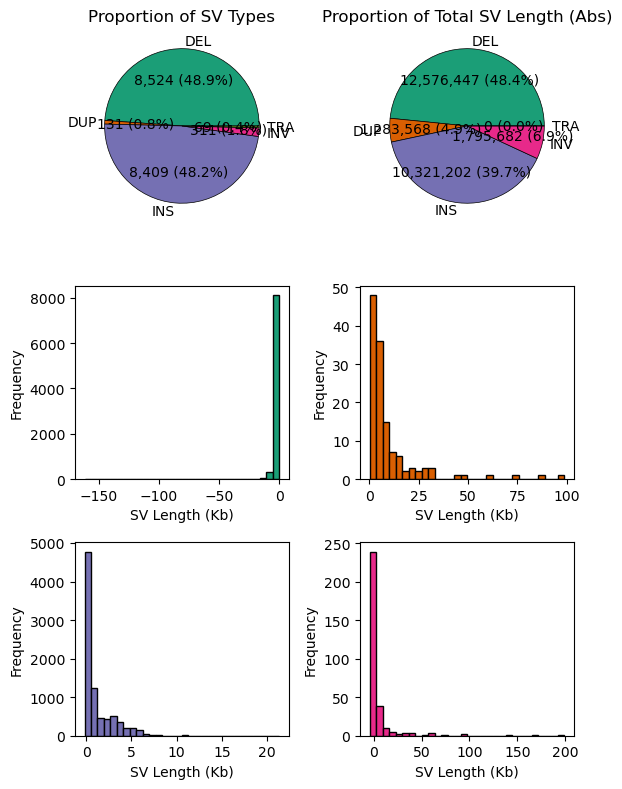

In [392]:
import os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Assuming you're already in the correct directory
df = pd.read_csv("merged_jedi.csv", sep=",", header=0)

# Define SV types for histograms and pie charts
histogram_svtypes = ["DEL", "DUP", "INS", "INV"]  # Exclude TRA from histograms
piechart_svtypes = ["DEL", "DUP", "INS", "INV", "TRA"]  # Include TRA for pie charts

# Calculate the number of occurrences of each SVTYPE
svtype_counts = df['svtype'].value_counts()

# Calculate the sum of the absolute SVLEN for each SVTYPE
svlen_sums = df.groupby('svtype')['svlen'].apply(lambda x: x.abs().sum())

# Use the "Dark2" colormap and create a color mapping for SV types
cmap = plt.get_cmap("Dark2")
color_mapping = {svtype: cmap(i) for i, svtype in enumerate(piechart_svtypes)}

# Custom function to show both value and percentage
def func(pct, allvals):
    absolute = int(pct/100.*np.sum(allvals))
    return f"{absolute:,} ({pct:.1f}%)"

# Create a figure with 6 subplots (3 rows, 2 columns)
fig, axs = plt.subplots(3, 2, figsize=(6, 8))

# Flatten the axs array for easier iteration
axs = axs.flatten()

# Place the pie charts at the top (indices 0 and 1)
# Add pie chart for the number of each SVTYPE (including TRA)
axs[0].pie(
    svtype_counts[piechart_svtypes], 
    labels=piechart_svtypes, 
    autopct=lambda pct: func(pct, svtype_counts[piechart_svtypes]), 
    colors=[color_mapping[svtype] for svtype in piechart_svtypes], 
    wedgeprops={"edgecolor": "black", "linewidth": 0.5}, 
)
axs[0].set_title('Proportion of SV Types')

# Add pie chart for the sum of absolute SVLEN for each SVTYPE (including TRA)
axs[1].pie(
    svlen_sums[piechart_svtypes], 
    labels=piechart_svtypes, 
    autopct=lambda pct: func(pct, svlen_sums[piechart_svtypes]), 
    colors=[color_mapping[svtype] for svtype in piechart_svtypes], 
    wedgeprops={"edgecolor": "black", "linewidth": 0.5}, 
)
axs[1].set_title('Proportion of Total SV Length (Abs)')

# Loop over the SV types and create a histogram for each (excluding TRA)
for i, svtype in enumerate(histogram_svtypes):
    # Filter the data for the current SV type
    data = df[df["svtype"] == svtype]["svlen"] / 1000
    
    # Plot the histogram with the corresponding color
    axs[i + 2].hist(data, bins=30, color=color_mapping[svtype], edgecolor='black')
    #axs[i + 2].set_title(f'{svtype.upper()} SV Length Distribution', fontsize=14)
    axs[i + 2].set_xlabel('SV Length (Kb)')
    axs[i + 2].set_ylabel('Frequency')

# Adjust layout to prevent overlap
plt.tight_layout()

# Save the figure
plt.savefig("../figures_and_tables/fig1_sv_histograms_and_piecharts.png", format="png", dpi=600, facecolor="white")
plt.savefig("../figures_and_tables/fig1_sv_histograms_and_piecharts.svg", facecolor="white")

# Show the plot
plt.show()


In [380]:
abs(df["svlen"]).sum()

25976899

In [381]:
genome_size = 397_918_904

(abs(df["svlen"]).sum()/genome_size)*100

6.528189221188647

## Figure 2 SV AF histograms

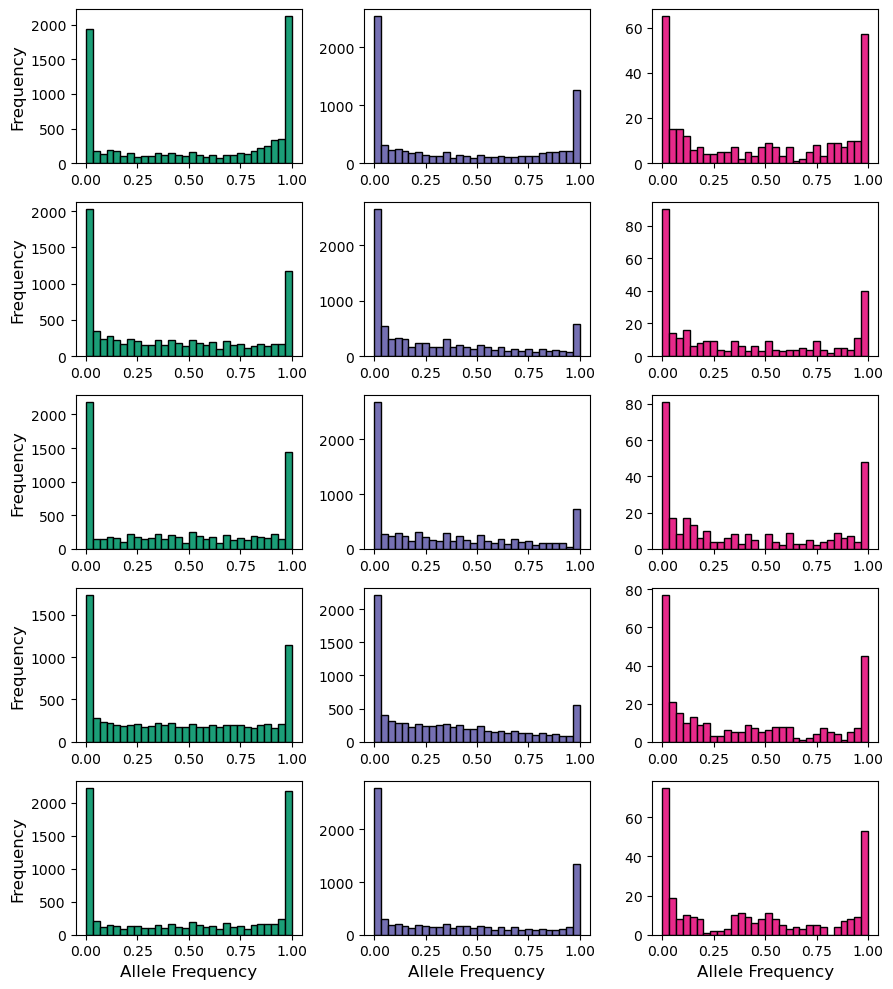

In [383]:
import os
import pandas as pd
import matplotlib.pyplot as plt

os.chdir("{}/results/process_sv_tables".format(proj_dir))

df = pd.read_csv("merged_jedi.csv", sep=",", header=0)

# Define the SV types and allele frequency columns
svtypes = ["DEL", "DUP", "INS", "INV", "TRA"]
af_columns = ['smbre.af', 'smeg.af', 'smle-pzq-er.af', 'smle-pzq-es.af', 'smor.af']

# Use the "Dark2" colormap and create a color mapping for SV types
cmap = plt.get_cmap("Dark2")
color_mapping = {svtype: cmap(i) for i, svtype in enumerate(svtypes)}

# Create a figure with len(af_columns) rows and len(svtypes) columns
fig, axs = plt.subplots(len(af_columns), len(["DEL", "INS", "INV"]), figsize=(9, 10))

# Loop over the rows (af_columns) and columns (svtypes)
for row_idx, af_col in enumerate(af_columns):
    for col_idx, svtype in enumerate(["DEL", "INS", "INV"]):
        # Filter the data for the current svtype
        data = df[df["svtype"] == svtype][af_col].dropna()  # Drop NA values for clean histograms
        
        # Plot the histogram with the corresponding color
        axs[row_idx, col_idx].hist(data, bins=30, color=color_mapping[svtype], edgecolor='black')
        #axs[row_idx, col_idx].set_title(f'{svtype} - {af_col}', fontsize=10)
        
        # Set labels only on the leftmost and bottom plots
        if col_idx == 0:
            axs[row_idx, col_idx].set_ylabel('Frequency', fontsize=12)
        if row_idx == len(af_columns) - 1:
            axs[row_idx, col_idx].set_xlabel('Allele Frequency', fontsize=12)

# Adjust layout to prevent overlap
plt.tight_layout()

# Save the figure
plt.savefig("../figures_and_tables/fig2_svtype_af_histograms.png", format="png", dpi=600, facecolor="white")
plt.savefig("../figures_and_tables/fig2_svtype_af_histograms.svg", facecolor="white")

# Show the plot
plt.show()


In [211]:
# Define the allele frequency columns
af_columns = ['smbre.af', 'smeg.af', 'smle-pzq-er.af', 'smle-pzq-es.af', 'smor.af']

# Create a mask to filter rows where any af_column is greater than 0.5 or greater than 0.95
mask = (df[af_columns] < 0.01).any(axis=1) | (df[af_columns] > 0.99).any(axis=1)

# Apply the mask to filter the DataFrame
filtered_df = df[mask]
filtered_df

,chrom,pos,end,id,ciend,svlen,svtype,smeg.gt,smeg.dp,smeg.ad,...,smle-pzq-es.pl,smor.gt,smor.dp,smor.ad,smor.pl,smbre.af,smeg.af,smle-pzq-er.af,smle-pzq-es.af,smor.af
1,SM_V10_1,147696,147696,cuteSV.INS.21,"0,0",273,INS,0/1,31.0,"23,8",...,"1402,19,2262",0/1,21.0,"17,4","134,25,693",0.000000,0.258065,0.416667,0.397959,0.190476
2,SM_V10_1,214189,214266,cuteSV.DEL.8,"0,0",-77,DEL,0/1,14.0,"12,2",...,"157,59,1404",0/1,31.0,"7,24","968,29,236",0.000000,0.142857,0.076923,0.128205,0.774194
4,SM_V10_1,237116,237116,cuteSV.INS.27,"0,0",279,INS,0/1,7.0,"5,2",...,"665,8,515",./.,2.0,"2,0","0,6,86",0.200000,0.285714,0.375000,0.555556,0.000000
11,SM_V10_1,311523,312186,cuteSV.DEL.40,"0,0",-663,DEL,0/1,69.0,"47,22",...,"391,184,4305",0/0,28.5,"28.5,0","0,85,1225",0.320513,0.318841,0.000000,0.111111,0.000000
14,SM_V10_1,380578,383435,cuteSV.DEL.29,"0,0",-2857,DEL,0/1,18.5,"7.5,11",...,"28,65,1082",./.,0.0,"0,0",".,.,.",0.333333,0.594595,0.000000,0.037736,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10904,SM_V10_Z,86660968,86660968,cuteSV.INS.16588,"0,0",253,INS,0/1,5.5,"5,0.5",...,"82,57,1049",0/0,22.0,"22,0","0,66,946",0.369369,0.090909,0.000000,0.090909,0.000000
10905,SM_V10_Z,86661751,86661751,cuteSV.INS.18290,"0,6",93,INS,0/1,8.0,"5,3",...,"572,8,443",0/0,21.0,"21,0","0,63,903",0.340000,0.375000,0.000000,0.555556,0.000000
10906,SM_V10_Z,86668354,86668354,cuteSV.INS.18298,"0,0",177,INS,0/1,9.0,"4,5",...,"1378,10,1378",0/0,31.0,"31,0","0,93,1333",0.413793,0.555556,0.000000,0.500000,0.000000
10907,SM_V10_Z,86680358,86680712,cuteSV.DEL.16744,"0,0",-354,DEL,0/0,5.0,"5,0",...,"32,22,419",0/1,14.0,"13,1","31,30,547",0.483871,0.000000,0.000000,0.090909,0.071429


In [216]:
# Define the allele frequency columns
af_columns = ['smbre.af', 'smeg.af', 'smle-pzq-er.af', 'smle-pzq-es.af', 'smor.af']

# Calculate the total number of variants for each svtype
total_counts = df.groupby("svtype").size()

# Initialize a dictionary to store results
percentage_results = {}

# Loop through each allele frequency column
for af_col in af_columns:
    # Apply the conditions for fixed variants by population and 'svtype'
    less_than_1 = df[df[af_col] == 0.0].groupby("svtype")[af_col].count()
    greater_than_99 = df[df[af_col] == 1].groupby("svtype")[af_col].count()
    
    # Combine the results
    extreme_counts = less_than_1.add(greater_than_99, fill_value=0)
    
    # Calculate the percentage
    percentage_results[af_col] = (extreme_counts / total_counts * 100).fillna(0)

# Convert the results dictionary to a DataFrame for easier viewing
percentage_results_df = pd.DataFrame(percentage_results)

# Display the resulting DataFrame
percentage_results_df


,smbre.af,smeg.af,smle-pzq-er.af,smle-pzq-es.af,smor.af
svtype,,,,,
DEL,43.887596,33.864328,37.479864,24.718096,50.241632
DUP,0.000000,0.000000,0.000000,0.000000,0.000000
INS,41.668314,33.722079,35.441787,23.542202,48.250642
INV,34.567901,31.481481,39.506173,28.395062,33.950617
TRA,0.000000,0.000000,0.000000,0.000000,0.000000


# PCA

In [433]:
Path("{}/results/pca_af".format(proj_dir)).mkdir(parents=True, exist_ok=True)
os.chdir("{}/results/pca_af".format(proj_dir))

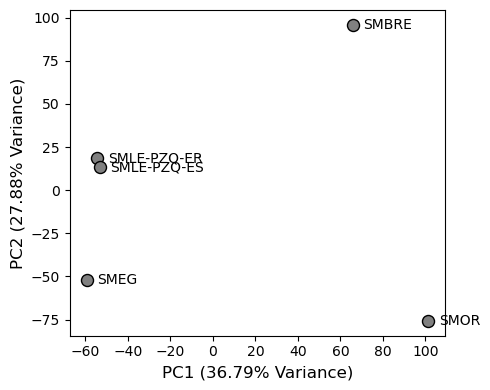

In [438]:
import os
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

os.chdir("{}/results/pca_af".format(proj_dir))

df = pd.read_csv("../process_sv_tables/merged_jedi.csv", sep=",", header=0)


# Assuming df is your DataFrame and contains the columns for PCA
columns_for_pca = ['smbre.af', 'smeg.af', 'smle-pzq-er.af', 'smle-pzq-es.af', 'smor.af']

# Extract the relevant columns (samples) for PCA
data_for_pca = df.loc[~df["chrom"].isin(["SM_V10_Z", "SM_V10_WSR", "SM_V10_MITO"]), columns_for_pca]

# Handle missing data by dropping rows with NaN values
data_for_pca = data_for_pca.dropna()

# Transpose the data so that rows represent samples and columns represent features
data_for_pca_transposed = data_for_pca.T

# Standardize the transposed data
scaler = StandardScaler()
scaled_data = scaler.fit_transform(data_for_pca_transposed)

# Perform PCA
pca = PCA(n_components=2)  # We'll compute the first two principal components
pca_result = pca.fit_transform(scaled_data)

# Create a DataFrame with the PCA results
pca_df = pd.DataFrame(pca_result, columns=['PC1', 'PC2'])

# Get the PC loadings
loadings = pd.DataFrame(pca.components_.T, columns=['PC1', 'PC2'], index=data_for_pca.index)
# Save the loadings to a CSV file
loadings.to_csv("pc_loadings.csv", index=True)

# Add sample names to the DataFrame
pca_df['Sample'] = columns_for_pca

# Plot the PCA results
plt.figure(figsize=(5, 4))
plt.scatter(pca_df['PC1'], pca_df['PC2'], c='grey', edgecolor='k', s=75)
plt.xlabel(f'PC1 ({pca.explained_variance_ratio_[0]*100:.2f}% Variance)', fontsize=12)
plt.ylabel(f'PC2 ({pca.explained_variance_ratio_[1]*100:.2f}% Variance)', fontsize=12)
# plt.title('PCA of SV Allele Frequencies')
for i, sample in enumerate(pca_df['Sample']):
    plt.text(pca_df['PC1'][i] + 5, pca_df['PC2'][i] + -2.5, sample.replace(".af", "").upper(), fontsize=10)
# plt.grid()
plt.tight_layout()

# save foivure
plt.savefig("../figures_and_tables/fig3_pca_af.png", format="png", dpi=600, facecolor="white")
plt.savefig("../figures_and_tables/fig3_pca_af.svg", facecolor="white")


plt.show()


In [441]:
(pca.explained_variance_ratio_[0] + pca.explained_variance_ratio_[1])*100

64.66674036150917

In [439]:
loadings

,PC1,PC2
7,-1.265377e-02,-5.397780e-04
8,-5.653712e-17,2.983687e-17
9,4.567804e-17,-7.111161e-17
10,1.125877e-02,-8.267996e-03
11,9.060948e-03,-1.014959e-02
...,...,...
14524,4.490296e-03,1.055595e-02
14531,5.816305e-03,1.214283e-02
14533,1.551770e-03,6.461511e-03
14534,9.097642e-03,-1.715343e-03


# Uniq SVs per pop

In [440]:
Path("{}/results/pop_specific_svs".format(proj_dir)).mkdir(parents=True, exist_ok=True)
os.chdir("{}/results/pop_specific_svs".format(proj_dir))

In [ ]:
df = pd.read_csv("../process_sv_tables/merged_jedi.csv", sep=",", header=0)

In [526]:
ids = [f"{z}-{x}:{y}" for x, y, z in zip(df["chrom"], df["pos"], df["svtype"])]
df["sv_id"]=ids

In [468]:
auto_df = df.loc[~df["chrom"].isin(["SM_V10_Z", "SM_V10_MITO", "SM_V10_WSR"])].reset_index(drop=True)

In [469]:
low_freq_cut_off = 0.05
er_svs = set(auto_df.loc[auto_df["smle-pzq-er.af"] > low_freq_cut_off, "sv_id"])
es_svs = set(auto_df.loc[auto_df["smle-pzq-es.af"] > low_freq_cut_off, "sv_id"])
eg_svs = set(auto_df.loc[auto_df["smeg.af"] > low_freq_cut_off, "sv_id"])
or_svs = set(auto_df.loc[auto_df["smor.af"] > low_freq_cut_off, "sv_id"])
bre_svs = set(auto_df.loc[auto_df["smbre.af"] > low_freq_cut_off, "sv_id"])

/master/nplatt/anaconda3/envs/sm_ont-svs/lib/python3.9/site-packages/venn/_backwards_compatibility.py:15: UserWarning: `get_labels()` is retained for backwards compatibility; use `generate_petal_labels()` or the higher level `venn()` instead
  warn((
/master/nplatt/anaconda3/envs/sm_ont-svs/lib/python3.9/site-packages/venn/_backwards_compatibility.py:30: UserWarning: `venn5()` is retained for backwards compatibility; use `venn()` instead
  warn((


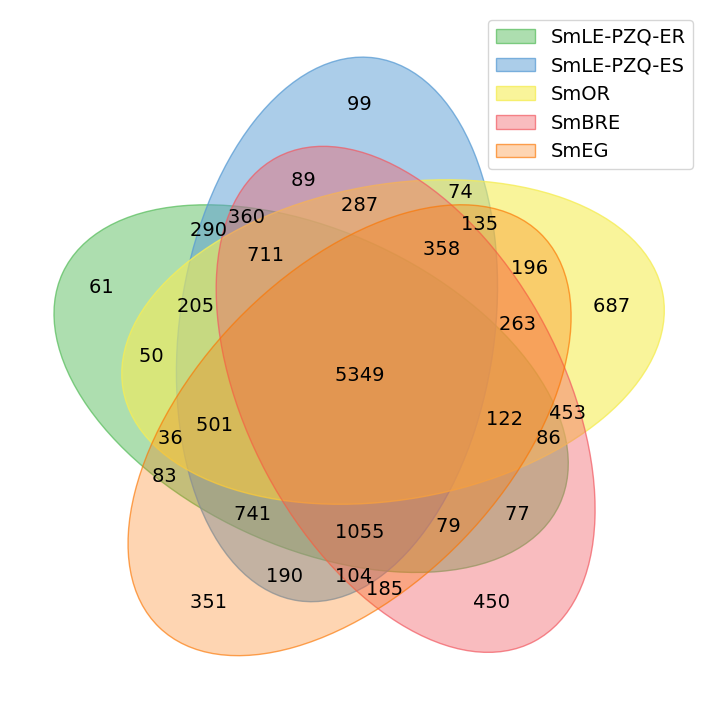

In [470]:
labels = venn.get_labels([er_svs, es_svs, or_svs, bre_svs, eg_svs], fill=["number"])

fig, ax = venn.venn2(
    labels, names=["SmLE-PZQ-ER", "SmLE-PZQ-ES", "SmOR", "SmBRE", "SmEG"]
)

# save foivure
fig.savefig("../figures_and_tables/fig4_venn_5perc.png", format="png", dpi=600, facecolor="white")
fig.savefig("../figures_and_tables/fig4_venn_5perc.svg", facecolor="white")

fig.show()

In [491]:
len(auto_df)

14536

In [471]:
# Unique to smle-pzq-er.af
unique_er_svs = er_svs - (es_svs | eg_svs | or_svs | bre_svs)

# Unique to smle-pzq-es.af
unique_es_svs = es_svs - (er_svs | eg_svs | or_svs | bre_svs)

# Unique to smeg.af
unique_eg_svs = eg_svs - (er_svs | es_svs | or_svs | bre_svs)

# Unique to smor.af
unique_or_svs = or_svs - (er_svs | es_svs | eg_svs | bre_svs)

# Unique to smbre.af
unique_bre_svs = bre_svs - (er_svs | es_svs | eg_svs | or_svs)


In [488]:
len(unique_er_svs) + len(unique_es_svs) + len(unique_eg_svs) + len(unique_or_svs) + len(unique_bre_svs) 

1648

In [483]:
df.loc[df["sv_id"].isin(unique_er_svs), "svtype"].value_counts()

svtype
INS    45
DEL    13
INV     3
Name: count, dtype: int64

In [484]:
df.loc[df["sv_id"].isin(unique_es_svs), "svtype"].value_counts()

svtype
INS    67
DEL    31
INV     1
Name: count, dtype: int64

In [485]:
df.loc[df["sv_id"].isin(unique_or_svs), "svtype"].value_counts()

svtype
INS    404
DEL    275
INV      8
Name: count, dtype: int64

In [486]:
df.loc[df["sv_id"].isin(unique_eg_svs), "svtype"].value_counts()

svtype
INS    188
DEL    158
INV      5
Name: count, dtype: int64

In [487]:
df.loc[df["sv_id"].isin(unique_bre_svs), "svtype"].value_counts()

svtype
INS    259
DEL    182
INV      9
Name: count, dtype: int64

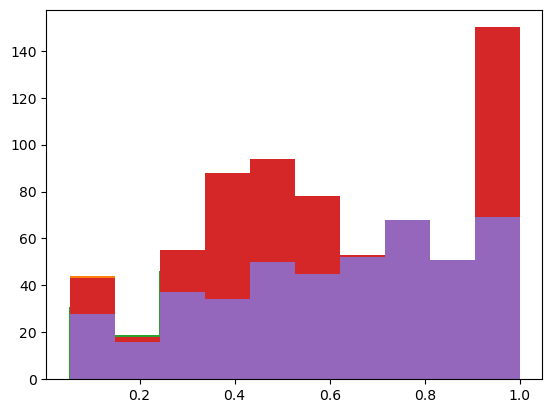

In [479]:
plt.hist(df.loc[df["sv_id"].isin(unique_er_svs), "smle-pzq-er.af"])
plt.hist(df.loc[df["sv_id"].isin(unique_es_svs), "smle-pzq-es.af"])
plt.hist(df.loc[df["sv_id"].isin(unique_eg_svs), "smeg.af"])
plt.hist(df.loc[df["sv_id"].isin(unique_or_svs), "smor.af"])
plt.hist(df.loc[df["sv_id"].isin(unique_bre_svs), "smbre.af"])

plt.show()

In [500]:
pop_specific_svs = list(unique_or_svs) + list(unique_bre_svs) +  list(unique_eg_svs) + list(unique_er_svs) + list(unique_es_svs)
df.loc[df["sv_id"].isin(pop_specific_svs)]

cutoff=0.95
pop_specific_df = df.loc[
    ((df['smbre.af'] >= cutoff) |
    (df['smeg.af'] >= cutoff) |
    (df['smle-pzq-er.af'] >= cutoff) |
    (df['smle-pzq-es.af']  >= cutoff) |
    (df['smor.af'] >= cutoff)) &
    df["sv_id"].isin(pop_specific_svs)
].dropna()

pop_specific_df

,chrom,pos,end,id,ciend,svlen,svtype,smeg.gt,smeg.dp,smeg.ad,...,smor.gt,smor.dp,smor.ad,smor.pl,smbre.af,smeg.af,smle-pzq-er.af,smle-pzq-es.af,smor.af,sv_id
840,SM_V10_1,18826864,18826864,cuteSV.INS.823,"0,0",99,INS,0/0,17.0,"17,0",...,1/1,22.0,"1,21","889,52,29",0.037037,0.0,0.000000,0.000000,0.954545,INS-SM_V10_1:18826864
867,SM_V10_1,19701652,19701652,cuteSV.INS.869,"0,0",128,INS,0/0,24.0,"24,0",...,1/1,25.0,"0,25","1075,75,0",0.000000,0.0,0.000000,0.000000,1.000000,INS-SM_V10_1:19701652
868,SM_V10_1,19706163,19706163,cuteSV.INS.871,"0,0",504,INS,0/0,31.0,"31,0",...,1/1,23.0,"0,23","989,69,0",0.000000,0.0,0.000000,0.022727,1.000000,INS-SM_V10_1:19706163
871,SM_V10_1,19722114,19722496,cuteSV.DEL.911,"0,0",-382,DEL,0/0,23.0,"23,0",...,1/1,27.0,"1,26","1103,66,28",0.000000,0.0,0.000000,0.000000,0.962963,DEL-SM_V10_1:19722114
874,SM_V10_1,19790938,19790938,cuteSV.INS.878,"0,0",121,INS,0/0,26.0,"26,0",...,1/1,21.0,"1,20","846,49,29",0.000000,0.0,0.045455,0.000000,0.952381,INS-SM_V10_1:19790938
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13020,SM_V10_6,17310756,17310756,cuteSV.INS.8757,"0,0",1186,INS,1/1,10.0,"0,10",...,0/0,27.0,"27,0","0,81,1161",0.000000,1.0,0.000000,0.000000,0.000000,INS-SM_V10_6:17310756
13608,SM_V10_7,1006769,1006853,cuteSV.DEL.13062,"0,0",-84,DEL,0/0,16.0,"16,0",...,0/0,21.0,"21,0","0,63,903",1.000000,0.0,0.000000,0.024390,0.000000,DEL-SM_V10_7:1006769
13858,SM_V10_7,6940305,6940563,cuteSV.DEL.8910,"0,0",-258,DEL,1/1,19.0,"0,19",...,0/0,30.0,"30,0","0,90,1290",0.000000,1.0,0.000000,0.000000,0.000000,DEL-SM_V10_7:6940305
13992,SM_V10_7,10557604,10557604,cuteSV.INS.12225,"0,0",91,INS,0/0,24.0,"24,0",...,1/1,27.0,"1,26","1103,66,28",0.000000,0.0,0.000000,0.000000,0.962963,INS-SM_V10_7:10557604


In [519]:
unique_sv_dict = {}

unique_sv_dict.update({sv: "smle-pzq-er" for sv in unique_er_svs})
unique_sv_dict.update({sv: "smle-pzq-es" for sv in unique_es_svs})
unique_sv_dict.update({sv: "smeg" for sv in unique_eg_svs})
unique_sv_dict.update({sv: "smor" for sv in unique_or_svs})
unique_sv_dict.update({sv: "smbre" for sv in unique_bre_svs})

pops = [unique_sv_dict[x] for x in pop_specific_df["sv_id"]]
pop_specific_df["specific_pop"] = pops
pop_specific_df.to_csv("../figures_and_tables/raw_pop_specific_svs.csv", sep=",", header=True, index=False)
pop_specific_df

,chrom,pos,end,id,ciend,svlen,svtype,smeg.gt,smeg.dp,smeg.ad,...,smor.dp,smor.ad,smor.pl,smbre.af,smeg.af,smle-pzq-er.af,smle-pzq-es.af,smor.af,sv_id,specific_pop
840,SM_V10_1,18826864,18826864,cuteSV.INS.823,"0,0",99,INS,0/0,17.0,"17,0",...,22.0,"1,21","889,52,29",0.037037,0.0,0.000000,0.000000,0.954545,INS-SM_V10_1:18826864,smor
867,SM_V10_1,19701652,19701652,cuteSV.INS.869,"0,0",128,INS,0/0,24.0,"24,0",...,25.0,"0,25","1075,75,0",0.000000,0.0,0.000000,0.000000,1.000000,INS-SM_V10_1:19701652,smor
868,SM_V10_1,19706163,19706163,cuteSV.INS.871,"0,0",504,INS,0/0,31.0,"31,0",...,23.0,"0,23","989,69,0",0.000000,0.0,0.000000,0.022727,1.000000,INS-SM_V10_1:19706163,smor
871,SM_V10_1,19722114,19722496,cuteSV.DEL.911,"0,0",-382,DEL,0/0,23.0,"23,0",...,27.0,"1,26","1103,66,28",0.000000,0.0,0.000000,0.000000,0.962963,DEL-SM_V10_1:19722114,smor
874,SM_V10_1,19790938,19790938,cuteSV.INS.878,"0,0",121,INS,0/0,26.0,"26,0",...,21.0,"1,20","846,49,29",0.000000,0.0,0.045455,0.000000,0.952381,INS-SM_V10_1:19790938,smor
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13020,SM_V10_6,17310756,17310756,cuteSV.INS.8757,"0,0",1186,INS,1/1,10.0,"0,10",...,27.0,"27,0","0,81,1161",0.000000,1.0,0.000000,0.000000,0.000000,INS-SM_V10_6:17310756,smeg
13608,SM_V10_7,1006769,1006853,cuteSV.DEL.13062,"0,0",-84,DEL,0/0,16.0,"16,0",...,21.0,"21,0","0,63,903",1.000000,0.0,0.000000,0.024390,0.000000,DEL-SM_V10_7:1006769,smbre
13858,SM_V10_7,6940305,6940563,cuteSV.DEL.8910,"0,0",-258,DEL,1/1,19.0,"0,19",...,30.0,"30,0","0,90,1290",0.000000,1.0,0.000000,0.000000,0.000000,DEL-SM_V10_7:6940305,smeg
13992,SM_V10_7,10557604,10557604,cuteSV.INS.12225,"0,0",91,INS,0/0,24.0,"24,0",...,27.0,"1,26","1103,66,28",0.000000,0.0,0.000000,0.000000,0.962963,INS-SM_V10_7:10557604,smor


In [517]:
tmp_df = pop_specific_df[["chrom", "pos", "end", "svtype", "smle-pzq-er.af", "smle-pzq-es.af", "smor.af", "smbre.af", "smeg.af", "specific_pop"]]
tmp_df.to_csv("../figures_and_tables/table-x_pop_specific_svs.csv", sep=",", header=True, index=False)

In [513]:
pop_specific_df["specific_pop"].value_counts()

specific_pop
smor     114
smbre     46
smeg       8
Name: count, dtype: int64

# Pop specific PCR primers for validation 

In [554]:
lens=abs(pop_specific_df["svlen"])
pop_specific_df.loc[ (lens<400) & (lens>100)]

,chrom,pos,end,id,ciend,svlen,svtype,smeg.gt,smeg.dp,smeg.ad,...,smor.dp,smor.ad,smor.pl,smbre.af,smeg.af,smle-pzq-er.af,smle-pzq-es.af,smor.af,sv_id,specific_pop
1,SM_V10_1,19701652,19701652,cuteSV.INS.869,"0,0",128,INS,0/0,24.0,"24,0",...,25.0,"0,25","1075,75,0",0.000000,0.000000,0.000000,0.000000,1.000000,INS-SM_V10_1:19701652,smor
3,SM_V10_1,19722114,19722496,cuteSV.DEL.911,"0,0",-382,DEL,0/0,23.0,"23,0",...,27.0,"1,26","1103,66,28",0.000000,0.000000,0.000000,0.000000,0.962963,DEL-SM_V10_1:19722114,smor
4,SM_V10_1,19790938,19790938,cuteSV.INS.878,"0,0",121,INS,0/0,26.0,"26,0",...,21.0,"1,20","846,49,29",0.000000,0.000000,0.045455,0.000000,0.952381,INS-SM_V10_1:19790938,smor
8,SM_V10_1,20567930,20568099,cuteSV.DEL.929,"0,0",-169,DEL,0/0,17.5,"17.5,0",...,17.0,"0,17","731,51,0",0.000000,0.000000,0.000000,0.000000,1.000000,DEL-SM_V10_1:20567930,smor
11,SM_V10_1,58896631,58896977,cuteSV.DEL.2047,"0,0",-346,DEL,0/0,14.0,"14,0",...,11.5,"0.5,11","473,34,21",0.000000,0.000000,0.000000,0.000000,0.956522,DEL-SM_V10_1:58896631,smor
14,SM_V10_1,83035674,83035778,cuteSV.DEL.2886,"0,0",-104,DEL,0/0,12.0,"12,0",...,34.0,"0,34","1462,102,0",0.000000,0.000000,0.000000,0.026316,1.000000,DEL-SM_V10_1:83035674,smor
20,SM_V10_2,268685,268812,cuteSV.DEL.3044,"0,0",-127,DEL,0/0,15.0,"15,0",...,10.0,"0,10","430,30,0",0.027027,0.000000,0.000000,0.019608,1.000000,DEL-SM_V10_2:268685,smor
21,SM_V10_2,270134,270490,cuteSV.DEL.3047,"0,0",-356,DEL,0/0,17.5,"17.5,0",...,10.0,"0,10","430,30,0",0.000000,0.000000,0.000000,0.020619,1.000000,DEL-SM_V10_2:270134,smor
22,SM_V10_2,273645,273955,cuteSV.DEL.3049,"0,0",-310,DEL,0/0,21.0,"21,0",...,18.0,"0,18","774,54,0",0.000000,0.000000,0.000000,0.000000,1.000000,DEL-SM_V10_2:273645,smor
31,SM_V10_2,446227,446389,cuteSV.DEL.3023,"0,0",-162,DEL,0/0,21.0,"20,1",...,24.0,"24,0","0,72,1032",1.000000,0.047619,0.000000,0.000000,0.000000,DEL-SM_V10_2:446227,smbre


# Add exon info

In [531]:
Path("{}/results/svs_vs_exons".format(proj_dir)).mkdir(parents=True, exist_ok=True)
os.chdir("{}/results/svs_vs_exons".format(proj_dir))

In [521]:
pop_specific_df = pd.read_csv("../figures_and_tables/raw_pop_specific_svs.csv", sep=",", header=0)
df = pd.read_csv("../process_sv_tables/merged_jedi.csv", sep=",", header=0)

In [529]:
pop_specific_df[["chrom", "pos", "end", "sv_id", ]].to_csv("pop_specific.bed", sep="\t", header=False, index=False)

In [ ]:
%%bash 

conda run --live-stream -n bedtools bedtools intersect -wo -a pop_specific.bed -b ../../data/genome/SM_V10.gtf >pop_specific_genes.bed

In [596]:
# Read the BED file resulting from the intersection
gtf_df = pd.read_csv("pop_specific_genes.bed", sep="\t", header=None)

gtf_df.columns = ["chrom", "start", "end", "name", "gtf_chrom", "gtf_source", "gtf_feature", "gtf_start", "gtf_end", "gtf_score", "gtf_strand", "gtf_frame", "gtf_attribute", "other"]
genes=[x.split(";")[0].replace("gene_id \"", "").replace("\"", "") for x in gtf_df["gtf_attribute"]]     
gtf_df["gene"] = genes
gtf_df

,chrom,start,end,name,gtf_chrom,gtf_source,gtf_feature,gtf_start,gtf_end,gtf_score,gtf_strand,gtf_frame,gtf_attribute,other,gene
0,SM_V10_1,18826864,18826864,INS-SM_V10_1:18826864,SM_V10_1,WormBase,gene,18810995,18855035,.,-,.,"gene_id ""Smp_069380""; gene_version ""1""; gene_s...",0,Smp_069380
1,SM_V10_1,18826864,18826864,INS-SM_V10_1:18826864,SM_V10_1,WormBase,transcript,18810995,18855035,.,-,.,"gene_id ""Smp_069380""; gene_version ""1""; transc...",0,Smp_069380
2,SM_V10_1,19701652,19701652,INS-SM_V10_1:19701652,SM_V10_1,WormBase,gene,19678969,19710653,.,+,.,"gene_id ""Smp_307220""; gene_version ""1""; gene_s...",0,Smp_307220
3,SM_V10_1,19701652,19701652,INS-SM_V10_1:19701652,SM_V10_1,WormBase,transcript,19678969,19710653,.,+,.,"gene_id ""Smp_307220""; gene_version ""1""; transc...",0,Smp_307220
4,SM_V10_1,19701652,19701652,INS-SM_V10_1:19701652,SM_V10_1,WormBase,transcript,19678969,19710653,.,+,.,"gene_id ""Smp_307220""; gene_version ""1""; transc...",0,Smp_307220
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
196,SM_V10_7,1006769,1006853,DEL-SM_V10_7:1006769,SM_V10_7,WormBase,transcript,958923,1011168,.,+,.,"gene_id ""Smp_341770""; gene_version ""1""; transc...",84,Smp_341770
197,SM_V10_7,6940305,6940563,DEL-SM_V10_7:6940305,SM_V10_7,WormBase,gene,6884850,6972451,.,+,.,"gene_id ""Smp_080870""; gene_version ""1""; gene_s...",258,Smp_080870
198,SM_V10_7,6940305,6940563,DEL-SM_V10_7:6940305,SM_V10_7,WormBase,transcript,6884850,6972451,.,+,.,"gene_id ""Smp_080870""; gene_version ""1""; transc...",258,Smp_080870
199,SM_V10_7,10557604,10557604,INS-SM_V10_7:10557604,SM_V10_7,WormBase,gene,10556982,10579272,.,-,.,"gene_id ""Smp_144660""; gene_version ""1""; gene_s...",0,Smp_144660


In [571]:
gtf_df["gtf_feature"].value_counts()

gtf_feature
transcript         84
gene               71
exon               19
CDS                15
five_prime_utr      5
three_prime_utr     3
start_codon         2
stop_codon          2
Name: count, dtype: int64

In [598]:
len(gtf_df["gene"].value_counts())

56

In [602]:
gtf_df.loc[gtf_df["gtf_feature"].isin(["CDS", "exon"]), "gene"].value_counts()

gene
Smp_327700    14
Smp_327710    14
Smp_315070     2
Smp_158710     2
Smp_076960     1
Smp_342090     1
Name: count, dtype: int64

In [607]:
gtf_df.loc[gtf_df["gtf_feature"].isin(["CDS", "exon"]), "name"].value_counts()


name
INV-SM_V10_2:3848692     28
DEL-SM_V10_6:6022561      2
INS-SM_V10_1:19941568     1
INS-SM_V10_6:603144       1
INS-SM_V10_6:603467       1
INS-SM_V10_6:13488241     1
Name: count, dtype: int64

In [609]:
gtf_df.loc[gtf_df["name"] == "INV-SM_V10_2:3848692"]

,chrom,start,end,name,gtf_chrom,gtf_source,gtf_feature,gtf_start,gtf_end,gtf_score,gtf_strand,gtf_frame,gtf_attribute,other,gene
56,SM_V10_2,3848692,3878697,INV-SM_V10_2:3848692,SM_V10_2,WormBase,gene,3857964,3863052,.,-,.,"gene_id ""Smp_327700""; gene_version ""1""; gene_s...",5089,Smp_327700
57,SM_V10_2,3848692,3878697,INV-SM_V10_2:3848692,SM_V10_2,WormBase,transcript,3857964,3863052,.,-,.,"gene_id ""Smp_327700""; gene_version ""1""; transc...",5089,Smp_327700
58,SM_V10_2,3848692,3878697,INV-SM_V10_2:3848692,SM_V10_2,WormBase,exon,3862951,3863052,.,-,.,"gene_id ""Smp_327700""; gene_version ""1""; transc...",102,Smp_327700
59,SM_V10_2,3848692,3878697,INV-SM_V10_2:3848692,SM_V10_2,WormBase,CDS,3862951,3863020,.,-,0,"gene_id ""Smp_327700""; gene_version ""1""; transc...",70,Smp_327700
60,SM_V10_2,3848692,3878697,INV-SM_V10_2:3848692,SM_V10_2,WormBase,start_codon,3863018,3863020,.,-,0,"gene_id ""Smp_327700""; gene_version ""1""; transc...",3,Smp_327700
61,SM_V10_2,3848692,3878697,INV-SM_V10_2:3848692,SM_V10_2,WormBase,exon,3861964,3861980,.,-,.,"gene_id ""Smp_327700""; gene_version ""1""; transc...",17,Smp_327700
62,SM_V10_2,3848692,3878697,INV-SM_V10_2:3848692,SM_V10_2,WormBase,CDS,3861964,3861980,.,-,2,"gene_id ""Smp_327700""; gene_version ""1""; transc...",17,Smp_327700
63,SM_V10_2,3848692,3878697,INV-SM_V10_2:3848692,SM_V10_2,WormBase,exon,3860764,3860781,.,-,.,"gene_id ""Smp_327700""; gene_version ""1""; transc...",18,Smp_327700
64,SM_V10_2,3848692,3878697,INV-SM_V10_2:3848692,SM_V10_2,WormBase,CDS,3860764,3860781,.,-,0,"gene_id ""Smp_327700""; gene_version ""1""; transc...",18,Smp_327700
65,SM_V10_2,3848692,3878697,INV-SM_V10_2:3848692,SM_V10_2,WormBase,exon,3859640,3859699,.,-,.,"gene_id ""Smp_327700""; gene_version ""1""; transc...",60,Smp_327700


In [610]:
3848692 - 3878697	

-30005

In [608]:
gtf_df.loc[gtf_df["gtf_feature"].isin(["three_prime_utr", "five_prime_utr"]), "name"].value_counts()

name
INV-SM_V10_2:3848692     4
INS-SM_V10_1:19941568    1
INS-SM_V10_6:603144      1
INS-SM_V10_6:603467      1
INS-SM_V10_6:13488241    1
Name: count, dtype: int64

In [611]:
gtf_df.loc[gtf_df["gtf_feature"].isin(["three_prime_utr", "five_prime_utr"]), "gene"].value_counts()

gene
Smp_327700    2
Smp_327710    2
Smp_315070    2
Smp_076960    1
Smp_342090    1
Name: count, dtype: int64

In [577]:
gtf_df["name"].value_counts()

name
INV-SM_V10_2:3848692     40
INS-SM_V10_2:6242361      4
INS-SM_V10_6:603467       4
INS-SM_V10_1:19706163     4
INS-SM_V10_2:6300021      4
                         ..
DEL-SM_V10_2:6150521      2
INS-SM_V10_2:6822233      2
INS-SM_V10_2:12004927     2
INS-SM_V10_2:40940581     2
INS-SM_V10_7:10557604     2
Name: count, Length: 70, dtype: int64

In [587]:
genes=[x.split(";")[0] for x in gtf_df["gtf_attribute"]]     
pd.Series(genes).value_counts()

gene_id "Smp_327700"    20
gene_id "Smp_327710"    20
gene_id "Smp_334580"    12
gene_id "Smp_315070"     8
gene_id "Smp_307220"     8
gene_id "Smp_021170"     8
gene_id "Smp_163500"     6
gene_id "Smp_346030"     6
gene_id "Smp_327360"     6
gene_id "Smp_076960"     4
gene_id "Smp_342090"     4
gene_id "Smp_133590"     4
gene_id "Smp_158710"     4
gene_id "Smp_122810"     4
gene_id "Smp_181080"     3
gene_id "Smp_121800"     3
gene_id "Smp_170890"     3
gene_id "Smp_317250"     2
gene_id "Smp_341770"     2
gene_id "Smp_000200"     2
gene_id "Smp_000180"     2
gene_id "Smp_000160"     2
gene_id "Smp_333630"     2
gene_id "Smp_080870"     2
gene_id "Smp_051930"     2
gene_id "Smp_153810"     2
gene_id "Smp_246520"     2
gene_id "Smp_070100"     2
gene_id "Smp_070250"     2
gene_id "Smp_247590"     2
gene_id "Smp_341070"     2
gene_id "Smp_342190"     2
gene_id "Smp_162180"     2
gene_id "Smp_069380"     2
gene_id "Smp_134080"     2
gene_id "Smp_159630"     2
gene_id "Smp_210300"     2
g

In [ ]:
coding_regions = ["exon", "CDS"]
gtf_df.loc

In [ ]:
exon               19
CDS                15
five_prime_utr      5
three_prime_utr     3

In [109]:
%%bash

awk '{if ($3=="exon") print $0}' /master/nplatt/sch_man_ont/data/genome/SM_V10.gtf >smv10_exons.gtf
grep -i utr /master/nplatt/sch_man_ont/data/genome/SM_V10.gtf >smv10_utrs.gtf

In [ ]:
# load exons and then UTRs into interval trees

In [110]:
utr_df = pd.read_csv("smv10_utrs.gtf", header=None, sep="\t")
genes = [x.split(";")[0].split(" ")[1].replace('"', "") for x in utr_df[8]]
utrs = utr_df[2]
labels = [f"{a}.{b}" for a, b in zip(utrs, genes)]
utr_df["label"] = labels
utr_bed = utr_df[[0, 3, 4, "label"]]
utr_bed.columns = ["chrom", "start", "stop", "name"]
utr_bed.to_csv("utr.bed", header=False, index=False, sep="\t")
utr_bed

,chrom,start,stop,name
0,SM_V10_1,68764,68783,five_prime_utr.Smp_329140
1,SM_V10_1,68427,68592,three_prime_utr.Smp_329140
2,SM_V10_1,131233,131262,five_prime_utr.Smp_315690
3,SM_V10_1,83503,83540,three_prime_utr.Smp_315690
4,SM_V10_1,131233,131262,five_prime_utr.Smp_315690
...,...,...,...,...
23766,SM_V10_WSR,5827501,5827538,five_prime_utr.Smp_331650
23767,SM_V10_WSR,5793000,5793258,three_prime_utr.Smp_331650
23768,SM_V10_WSR,5791720,5792305,three_prime_utr.Smp_331650
23769,SM_V10_WSR,5829358,5829417,five_prime_utr.Smp_349550


In [111]:
exon_df = pd.read_csv("smv10_exons.gtf", header=None, sep="\t")
genes = [x.split(";")[0].split(" ")[1].replace('"', "") for x in exon_df[8]]
exon_df["gene"] = genes
exon_bed = exon_df[[0, 3, 4, "gene"]]
exon_bed.columns = ["chrom", "start", "stop", "name"]
exon_bed.to_csv("exon.bed", header=False, index=False, sep="\t")
exon_bed

,chrom,start,stop,name
0,SM_V10_1,68427,68783,Smp_329140
1,SM_V10_1,131175,131262,Smp_315690
2,SM_V10_1,125495,125778,Smp_315690
3,SM_V10_1,123081,123305,Smp_315690
4,SM_V10_1,83503,83870,Smp_315690
...,...,...,...,...
88807,SM_V10_MITO,11602,11787,Smp_900090
88808,SM_V10_MITO,11791,12861,Smp_900090
88809,SM_V10_MITO,13064,13348,Smp_900100
88810,SM_V10_MITO,13537,13749,Smp_900110


In [112]:
df["exon"] = "."
df["utr"] = "."
df

,chrom,pos,end,id,ciend,svlen,svtype,smeg.gt,smeg.dp,smeg.ad,...,smor.dp,smor.ad,smor.pl,smbre.af,smeg.af,smle-pzq-es.af,smle-pzq-er.af,smor.af,exon,utr
0,SM_V10_1,13414,19782952,cuteSV.BND.2,"0,0",0,TRA,./.,0.0,"0,0",...,0.0,"0,0",".,.,.",NaN,NaN,NaN,NaN,NaN,.,.
1,SM_V10_1,147696,147696,cuteSV.INS.21,"0,0",273,INS,0/1,31.0,"23,8",...,21.0,"17,4","134,25,693",0.000000,0.258065,0.397959,0.416667,0.190476,.,.
2,SM_V10_1,214189,214266,cuteSV.DEL.8,"0,0",-77,DEL,0/1,14.0,"12,2",...,31.0,"7,24","968,29,236",0.000000,0.142857,0.128205,0.076923,0.774194,.,.
3,SM_V10_1,214179,214179,cuteSV.INS.25,"0,36",59,INS,0/1,14.0,"10,4",...,31.0,"23,8","275,24,920",0.818182,0.285714,0.564103,0.846154,0.258065,.,.
4,SM_V10_1,237116,237116,cuteSV.INS.27,"0,0",279,INS,0/1,7.0,"5,2",...,2.0,"2,0","0,6,86",0.200000,0.285714,0.555556,0.375000,0.000000,.,.
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10904,SM_V10_Z,86660968,86660968,cuteSV.INS.16588,"0,0",253,INS,0/1,5.5,"5,0.5",...,22.0,"22,0","0,66,946",0.369369,0.090909,0.090909,0.000000,0.000000,.,.
10905,SM_V10_Z,86661751,86661751,cuteSV.INS.18290,"0,6",93,INS,0/1,8.0,"5,3",...,21.0,"21,0","0,63,903",0.340000,0.375000,0.555556,0.000000,0.000000,.,.
10906,SM_V10_Z,86668354,86668354,cuteSV.INS.18298,"0,0",177,INS,0/1,9.0,"4,5",...,31.0,"31,0","0,93,1333",0.413793,0.555556,0.500000,0.000000,0.000000,.,.
10907,SM_V10_Z,86680358,86680712,cuteSV.DEL.16744,"0,0",-354,DEL,0/0,5.0,"5,0",...,14.0,"13,1","31,30,547",0.483871,0.000000,0.090909,0.000000,0.071429,.,.


In [113]:
df["svtype"].value_counts()

svtype
DEL    5587
INS    5059
INV     162
DUP      79
TRA      22
Name: count, dtype: int64

In [114]:
utr_tree = defaultdict(IntervalTree)

# Iterate through each row in the DataFrame
for index, row in tqdm(utr_bed.iterrows()):

    chrom, start, end, name = row["chrom"], row["start"], row["stop"], row["name"]
    utr_tree[chrom].addi(start, end + 1, name)

23771it [00:01, 12854.95it/s]


In [115]:
exon_tree = defaultdict(IntervalTree)

# Iterate through each row in the DataFrame
for index, row in tqdm(exon_bed.iterrows()):

    chrom, start, end, name = row["chrom"], row["start"], row["stop"], row["name"]
    exon_tree[chrom].addi(start, end + 1, name)

88812it [00:06, 12841.30it/s]


In [116]:
for index, row in tqdm(df.iterrows()):
    chrom, pos, end = row["chrom"], row["pos"], row["end"]

    df.at[index, "utr"] = ":".join(
        [interval.data for interval in utr_tree[chrom][pos:end]]
    )
    df.at[index, "exon"] = ":".join(
        [interval.data for interval in exon_tree[chrom][pos:end]]
    )

df.to_csv("svs_and_features.tsv", header=True, index=False, sep="\t")
df

10909it [00:01, 7309.02it/s]


,chrom,pos,end,id,ciend,svlen,svtype,smeg.gt,smeg.dp,smeg.ad,...,smor.dp,smor.ad,smor.pl,smbre.af,smeg.af,smle-pzq-es.af,smle-pzq-er.af,smor.af,exon,utr
0,SM_V10_1,13414,19782952,cuteSV.BND.2,"0,0",0,TRA,./.,0.0,"0,0",...,0.0,"0,0",".,.,.",NaN,NaN,NaN,NaN,NaN,Smp_333290:Smp_345080:Smp_176780:Smp_175270:Sm...,three_prime_utr.Smp_171010:five_prime_utr.Smp_...
1,SM_V10_1,147696,147696,cuteSV.INS.21,"0,0",273,INS,0/1,31.0,"23,8",...,21.0,"17,4","134,25,693",0.000000,0.258065,0.397959,0.416667,0.190476,,
2,SM_V10_1,214189,214266,cuteSV.DEL.8,"0,0",-77,DEL,0/1,14.0,"12,2",...,31.0,"7,24","968,29,236",0.000000,0.142857,0.128205,0.076923,0.774194,,
3,SM_V10_1,214179,214179,cuteSV.INS.25,"0,36",59,INS,0/1,14.0,"10,4",...,31.0,"23,8","275,24,920",0.818182,0.285714,0.564103,0.846154,0.258065,,
4,SM_V10_1,237116,237116,cuteSV.INS.27,"0,0",279,INS,0/1,7.0,"5,2",...,2.0,"2,0","0,6,86",0.200000,0.285714,0.555556,0.375000,0.000000,,
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10904,SM_V10_Z,86660968,86660968,cuteSV.INS.16588,"0,0",253,INS,0/1,5.5,"5,0.5",...,22.0,"22,0","0,66,946",0.369369,0.090909,0.090909,0.000000,0.000000,,
10905,SM_V10_Z,86661751,86661751,cuteSV.INS.18290,"0,6",93,INS,0/1,8.0,"5,3",...,21.0,"21,0","0,63,903",0.340000,0.375000,0.555556,0.000000,0.000000,,
10906,SM_V10_Z,86668354,86668354,cuteSV.INS.18298,"0,0",177,INS,0/1,9.0,"4,5",...,31.0,"31,0","0,93,1333",0.413793,0.555556,0.500000,0.000000,0.000000,,
10907,SM_V10_Z,86680358,86680712,cuteSV.DEL.16744,"0,0",-354,DEL,0/0,5.0,"5,0",...,14.0,"13,1","31,30,547",0.483871,0.000000,0.090909,0.000000,0.071429,,


In [119]:
df.loc[df["exon"] != ""]

,chrom,pos,end,id,ciend,svlen,svtype,smeg.gt,smeg.dp,smeg.ad,...,smor.dp,smor.ad,smor.pl,smbre.af,smeg.af,smle-pzq-es.af,smle-pzq-er.af,smor.af,exon,utr
0,SM_V10_1,13414,19782952,cuteSV.BND.2,"0,0",0,TRA,./.,0.0,"0,0",...,0.0,"0,0",".,.,.",NaN,NaN,NaN,NaN,NaN,Smp_333290:Smp_345080:Smp_176780:Smp_175270:Sm...,three_prime_utr.Smp_171010:five_prime_utr.Smp_...
9,SM_V10_1,265107,265393,cuteSV.DEL.8,"0,0",-286,DEL,0/1,59.0,"48,11",...,74.0,"24,50","1958,30,839",0.608247,0.186441,0.355372,0.729730,0.675676,Smp_318880,five_prime_utr.Smp_318880
43,SM_V10_1,1024112,1059196,cuteSV.DEL.40,"-5,2",-35083,DEL,1/1,34.5,"1.5,33",...,44.0,"0,44","1892,132,0",1.000000,0.956522,1.000000,1.000000,1.000000,Smp_165590:Smp_165590:Smp_165590:Smp_165590:Sm...,five_prime_utr.Smp_165590
140,SM_V10_1,3087702,3093427,cuteSV.DEL.213,"-69,0",-5692,DEL,0/1,11.5,"2.5,9",...,25.0,"0,25","1075,75,0",0.500000,0.782609,0.772727,0.482759,1.000000,Smp_337450,
150,SM_V10_1,3398329,4706403,cuteSV.BND.32,"0,0",0,TRA,./.,0.0,"0,0",...,0.0,"0,0",".,.,.",NaN,NaN,NaN,NaN,NaN,Smp_334240:Smp_067060:Smp_244700:Smp_306440:Sm...,five_prime_utr.Smp_345790:five_prime_utr.Smp_1...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10818,SM_V10_Z,84047261,84047356,cuteSV.DEL.16636,"0,0",-95,DEL,0/1,15.0,"11,4",...,34.0,"13,21","813,12,469",0.451613,0.266667,0.016949,0.000000,0.617647,Smp_026510,five_prime_utr.Smp_026510
10843,SM_V10_Z,84813830,84813991,cuteSV.DEL.11008,"0,0",-161,DEL,0/1,21.5,"9.5,12",...,24.0,"24,0","0,72,1032",0.000000,0.558140,0.000000,0.333333,0.000000,Smp_333410,three_prime_utr.Smp_333410
10874,SM_V10_Z,86171664,86175909,cuteSV.DUP.409,"0,0",4245,DUP,./.,0.0,"0,0",...,0.0,"0,0",".,.,.",NaN,NaN,NaN,NaN,NaN,Smp_198890,five_prime_utr.Smp_198890
10876,SM_V10_Z,86181019,86181727,cuteSV.DEL.11059,"0,0",-708,DEL,0/1,8.5,"7.5,1",...,11.5,"11.5,0","0,34,494",0.000000,0.117647,0.000000,0.000000,0.000000,Smp_198890,five_prime_utr.Smp_198890


# automate igv snapshots

In [592]:
Path("{}/results/igv".format(proj_dir)).mkdir(parents=True, exist_ok=True)
os.chdir("{}/results/igv".format(proj_dir))

In [593]:
%%bash 

conda run -n igv --cwd . --live-stream \
    create_report \
        ../process_sv_tables/to_validate_subsampled.vcf \
        --fasta ../../data/genome/SM_V10.fa \
        --tracks ../process_sv_tables/to_validate_subsampled.vcf ../minimap2/smeg.bam ../minimap2/smor.bam ../minimap2/smle-pzq-er.bam ../minimap2/smle-pzq-es.bam ../minimap2/smbre.bam \
        --flanking 100

[W::bcf_hdr_check_sanity] PL should be declared as Number=G


Working on variant 1/40
Working on variant 2/40
Working on variant 3/40
Working on variant 4/40
Working on variant 5/40
Working on variant 6/40
Working on variant 7/40
Working on variant 8/40
Working on variant 9/40
Working on variant 10/40
Working on variant 11/40
Working on variant 12/40
Working on variant 13/40
Working on variant 14/40
Working on variant 15/40
Working on variant 16/40
Working on variant 17/40
Working on variant 18/40
Working on variant 19/40
Working on variant 20/40
Working on variant 21/40
Working on variant 22/40
Working on variant 23/40
Working on variant 24/40
Working on variant 25/40
Working on variant 26/40
Working on variant 27/40
Working on variant 28/40
Working on variant 29/40
Working on variant 30/40
Working on variant 31/40
Working on variant 32/40
Working on variant 33/40
Working on variant 34/40
Working on variant 35/40
Working on variant 36/40
Working on variant 37/40
Working on variant 38/40
Working on variant 39/40
Working on variant 40/40


# Sampling precision

In [619]:
from scipy.stats import hypergeom

def find_min_percentage_confidence(N, n, confidence_level=0.95):
    for k in range(1, N+1):
        rv = hypergeom(N, k, n)
        P_X_eq_0 = rv.pmf(0)
        P_X_ge_1 = 1 - P_X_eq_0
        if P_X_ge_1 >= confidence_level:
            return (k / N) * 100  # Return the percentage

# Example parameters
N = 100  # Total number of SVs in the population
n = 17   # Number of SVs sampled

# Find the smallest percentage with 95% confidence
min_percentage = find_min_percentage_confidence(N, n, confidence_level=0.95)
print(f"The smallest percentage of SVs you can sample with 95% confidence is approximately {min_percentage:.2f}%")


The smallest percentage of SVs you can sample with 95% confidence is approximately 15.00%


# Liftover coordinates

In [642]:
Path("{}/results/qtls".format(proj_dir)).mkdir(parents=True, exist_ok=True)
os.chdir("{}/results/qtls".format(proj_dir))

In [ ]:
%%bash

conda activate liftover

echo -e """SM_V7_1\t42010946\t53482618
SM_V7_2\t43954213\t47725512
SM_V7_3\t3914558\t5238304
SM_V7_4\t27609036\t30741077
SM_V7_5\t19823314\t23768112""">v7_coords.bed

minimap2 -cx asm5 -t 96 SM_V10.fa Smansoni_v7.fa >v7_to_v10.paf
paftools.js liftover v7_to_v10.paf v7_coords.bed  >v10_coords.bed

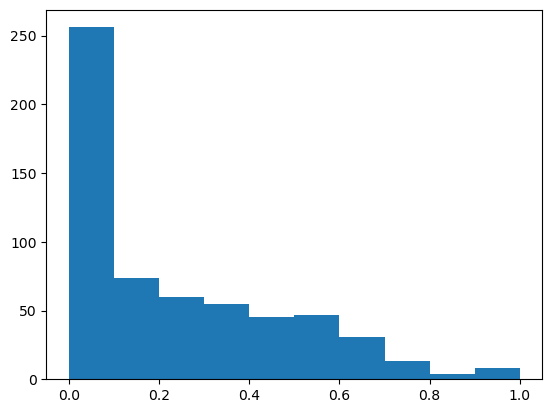

In [692]:
a = df.loc[ ((df["chrom"] == "SM_V10_3") &
         (df["pos"] >= 271314) &
         (df["end"] <=5994738))].dropna()

j=a["smle-pzq-er.af"]
k=a["smle-pzq-es.af"]
plt.hist(abs(j-k))
plt.show()

In [693]:
a.loc[abs(a["smle-pzq-er.af"] - a["smle-pzq-es.af"])>0.95]

,chrom,pos,end,id,ciend,svlen,svtype,smeg.gt,smeg.dp,smeg.ad,...,smor.gt,smor.dp,smor.ad,smor.pl,smbre.af,smeg.af,smle-pzq-er.af,smle-pzq-es.af,smor.af,sv_id
5846,SM_V10_3,2889598,2889650,cuteSV.DEL.7862,"-1,0",-52,DEL,1/1,19.0,"0,19",...,0/0,14.0,"14,0","0,42,602",0.000000,1.0000,0.0,0.972222,0.000000,DEL-SM_V10_3:2889598
5847,SM_V10_3,2897318,2898875,cuteSV.DEL.3312,"0,16",-1556,DEL,0/0,20.5,"20.5,0",...,1/1,15.0,"0,15","645,45,0",1.000000,0.0000,1.0,0.031250,1.000000,DEL-SM_V10_3:2897318
5853,SM_V10_3,2926900,2936162,cuteSV.DEL.5218,"0,0",-9262,DEL,0/0,14.5,"14.5,0",...,1/1,22.5,"1.5,21","879,43,40",0.958333,0.0000,1.0,0.000000,0.933333,DEL-SM_V10_3:2926900
5854,SM_V10_3,2969428,2973340,cuteSV.DEL.7865,"0,1",-3912,DEL,1/1,27.0,"0,27",...,0/1,27.0,"13,14","529,8,486",0.000000,1.0000,0.0,1.000000,0.518519,DEL-SM_V10_3:2969428
5875,SM_V10_3,3194040,3194564,cuteSV.DEL.5562,"0,0",-524,DEL,0/0,27.0,"27,0",...,0/1,16.0,"13,3","101,20,531",0.777778,0.0000,1.0,0.041237,0.187500,DEL-SM_V10_3:3194040
5930,SM_V10_3,3549244,3549572,cuteSV.DEL.7892,"0,49",-359,DEL,1/1,16.0,"1,15",...,0/0,26.0,"25,1","28,64,1061",0.157895,0.9375,0.0,0.975000,0.038462,DEL-SM_V10_3:3549244


In [694]:
a.loc[abs(a["smle-pzq-er.af"] - a["smle-pzq-es.af"])>0.95, ["chrom", "pos", "end", "sv_id"]].to_csv("pzq_svs.bed", sep="\t", header=False, index=False)

In [ ]:
conda run --live-stream -n bedtools bedtools intersect -wo -a pzq_svs.bed -b ../../data/genome/SM_V10.gtf

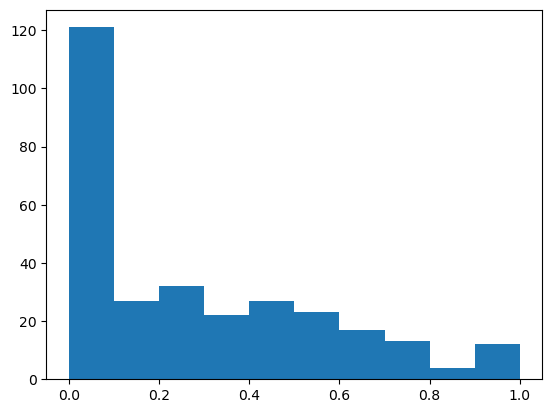

,chrom,pos,end,id,ciend,svlen,svtype,smeg.gt,smeg.dp,smeg.ad,...,smor.gt,smor.dp,smor.ad,smor.pl,smbre.af,smeg.af,smle-pzq-er.af,smle-pzq-es.af,smor.af,sv_id


In [653]:
a = df.loc[ ((df["chrom"] == "SM_V10_1") &
         (df["pos"] >= 41070262) &
         (df["end"] <=52541936))].dropna()

j=a["smbre.af"]
k=a["smle-pzq-er.af"]
plt.hist(abs(j-k))
plt.show()

a.loc[abs(a["smbre.af"] - a["smle-pzq-es.af"])>0.95]

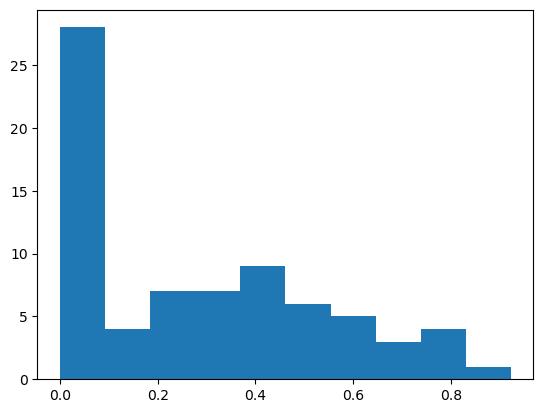

,chrom,pos,end,id,ciend,svlen,svtype,smeg.gt,smeg.dp,smeg.ad,...,smor.gt,smor.dp,smor.ad,smor.pl,smbre.af,smeg.af,smle-pzq-er.af,smle-pzq-es.af,smor.af,sv_id


In [656]:
a = df.loc[ ((df["chrom"] == "SM_V10_3") &
         (df["pos"] >= 5895758) &
         (df["end"] <=7219504))].dropna()

j=a["smbre.af"]
k=a["smle-pzq-er.af"]
d=abs(j-k)

plt.hist(d)
plt.show()

a.loc[d>0.95]

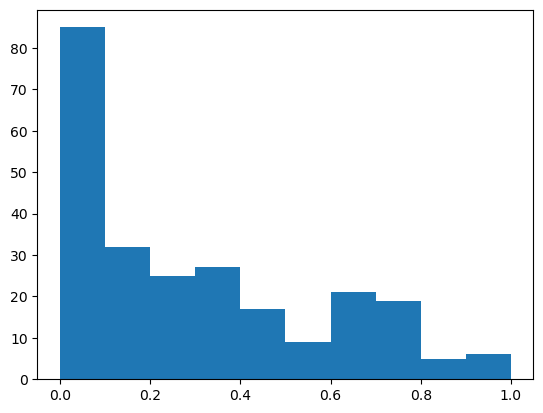

,chrom,pos,end,id,ciend,svlen,svtype,smeg.gt,smeg.dp,smeg.ad,...,smor.gt,smor.dp,smor.ad,smor.pl,smbre.af,smeg.af,smle-pzq-er.af,smle-pzq-es.af,smor.af,sv_id
5241,SM_V10_2,41902922,41902922,cuteSV.INS.5127,"0,42",76,INS,0/0,18.0,"18,0",...,0/1,29.0,"17,12","438,10,654",1.000000,0.000000,0.000000,0.0,0.413793,INS-SM_V10_2:41902922
5291,SM_V10_2,42927789,42928211,cuteSV.DEL.3715,"-1,0",-423,DEL,0/1,12.0,"2,10",...,0/0,25.0,"25,0","0,75,1075",0.961538,0.833333,0.066667,0.0,0.000000,DEL-SM_V10_2:42927789
5293,SM_V10_2,42931108,42931108,cuteSV.INS.3953,"-1,0",111,INS,0/1,11.0,"3,8",...,0/0,30.0,"29,1","28,75,1232",0.965517,0.727273,0.052632,0.0,0.033333,INS-SM_V10_2:42931108


In [691]:
a = df.loc[ ((df["chrom"] == "SM_V10_2") &
         (df["pos"] >= 41597599) &
         (df["end"] <=45311388))].dropna()

j=a["smbre.af"]
k=a["smle-pzq-es.af"]
d=abs(j-k)

plt.hist(d)
plt.show()

a.loc[d>0.95]

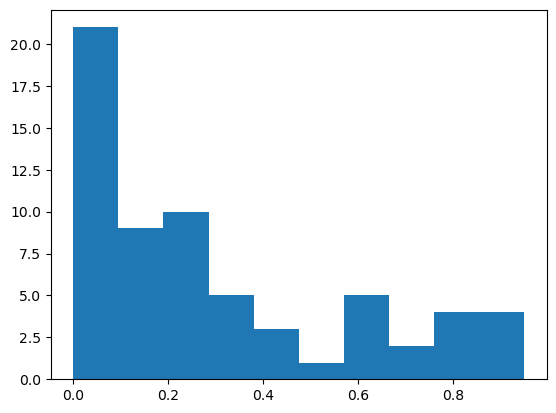

,chrom,pos,end,id,ciend,svlen,svtype,smeg.gt,smeg.dp,smeg.ad,...,smor.gt,smor.dp,smor.ad,smor.pl,smbre.af,smeg.af,smle-pzq-er.af,smle-pzq-es.af,smor.af,sv_id


In [662]:
a = df.loc[ ((df["chrom"] == "SM_V10_4") &
         (df["pos"] >= 26999137) &
         (df["end"] <=30131178))].dropna()

j=a["smbre.af"]
k=a["smle-pzq-er.af"]
d=abs(j-k)

plt.hist(d)
plt.show()

a.loc[d>0.95]

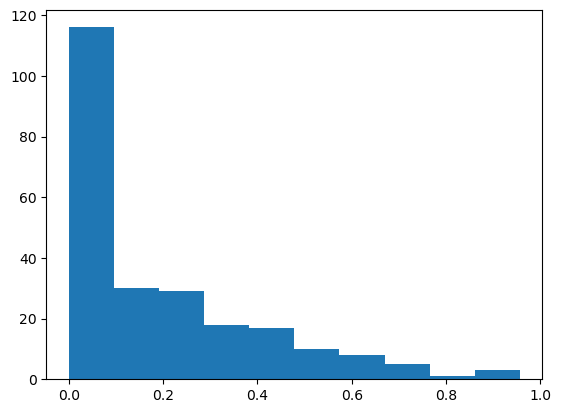

,chrom,pos,end,id,ciend,svlen,svtype,smeg.gt,smeg.dp,smeg.ad,...,smor.gt,smor.dp,smor.ad,smor.pl,smbre.af,smeg.af,smle-pzq-er.af,smle-pzq-es.af,smor.af,sv_id
12039,SM_V10_5,21925347,21925347,cuteSV.INS.12446,"0,0",6140,INS,./.,0.5,"0,0.5",...,0/0,26.0,"26,0","0,78,1118",0.043478,1.0,1.0,1.0,0.0,INS-SM_V10_5:21925347


In [690]:
a = df.loc[ ((df["chrom"] == "SM_V10_5") &
         (df["pos"] >= 18834925) &
         (df["end"] <=22640851))].dropna()

j=a["smbre.af"]
k=a["smle-pzq-es.af"]
d=abs(j-k)

plt.hist(d)
plt.show()

a.loc[d>0.95]

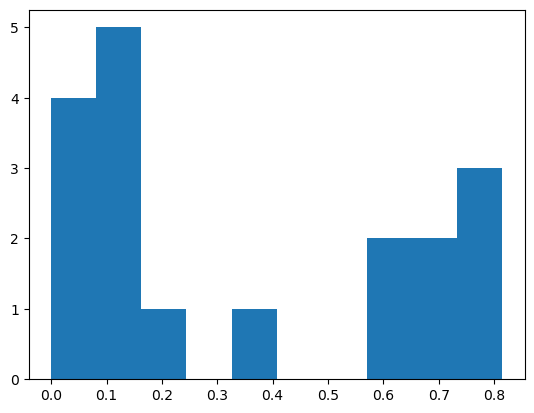

,chrom,pos,end,id,ciend,svlen,svtype,smeg.gt,smeg.dp,smeg.ad,...,smor.gt,smor.dp,smor.ad,smor.pl,smbre.af,smeg.af,smle-pzq-er.af,smle-pzq-es.af,smor.af,sv_id


In [687]:
a = df.loc[ ((df["chrom"] == "SM_V10_1") &
         (df["pos"] >= 84181459) &
         (df["end"] <=84946614))].dropna()

j=a["smbre.af"]
k=a["smle-pzq-es.af"]
d=abs(j-k)

plt.hist(d)
plt.show()

a.loc[d>0.95]

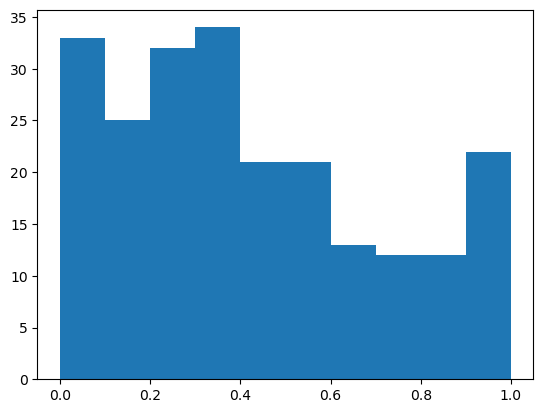

,chrom,pos,end,id,ciend,svlen,svtype,smeg.gt,smeg.dp,smeg.ad,...,smor.gt,smor.dp,smor.ad,smor.pl,smbre.af,smeg.af,smle-pzq-er.af,smle-pzq-es.af,smor.af,sv_id
5953,SM_V10_3,3932998,3933163,cuteSV.DEL.7928,"0,0",-165,DEL,0/0,18.0,"17,1",...,0/0,23.0,"23,0","0,69,989",0.0,0.055556,0.294118,0.952381,0.000000,DEL-SM_V10_3:3932998
5954,SM_V10_3,3934664,3934892,cuteSV.DEL.7930,"0,0",-228,DEL,0/1,16.0,"14,2",...,0/0,24.5,"24.5,0","0,73,1053",0.0,0.125000,0.312500,0.974359,0.000000,DEL-SM_V10_3:3934664
5955,SM_V10_3,3935330,3935688,cuteSV.DEL.7931,"0,0",-358,DEL,0/1,14.5,"11.5,3",...,0/0,26.0,"26,0","0,78,1118",0.0,0.206897,0.312500,0.974359,0.000000,DEL-SM_V10_3:3935330
5956,SM_V10_3,3936033,3938821,cuteSV.DEL.7932,"0,0",-2788,DEL,0/1,11.5,"8.5,3",...,0/0,19.0,"19,0","0,57,817",0.0,0.260870,0.357143,0.988235,0.000000,DEL-SM_V10_3:3936033
5975,SM_V10_3,4058825,4059310,cuteSV.DEL.7955,"0,0",-485,DEL,0/1,21.0,"14,7",...,0/1,28.5,"4.5,24","989,42,150",0.0,0.333333,0.545455,0.960784,0.842105,DEL-SM_V10_3:4058825
5998,SM_V10_3,4588169,4593667,cuteSV.DEL.8017,"0,0",-5498,DEL,0/1,19.0,"14,5",...,0/0,28.5,"27.5,1","28,71,1168",0.0,0.263158,1.000000,0.977273,0.035088,DEL-SM_V10_3:4588169
5999,SM_V10_3,4600290,4600290,cuteSV.INS.6114,"0,0",595,INS,0/1,24.0,"20,4",...,0/0,20.0,"20,0","0,60,860",0.0,0.166667,1.000000,0.974026,0.000000,INS-SM_V10_3:4600290
6008,SM_V10_3,4638185,4641959,cuteSV.DEL.8034,"-1,0",-3774,DEL,0/1,21.0,"14,7",...,0/1,20.5,"18.5,2","63,38,772",0.0,0.333333,1.000000,1.000000,0.097561,DEL-SM_V10_3:4638185
6009,SM_V10_3,4653737,4653737,cuteSV.INS.6129,"0,0",111,INS,0/1,27.0,"21,6",...,0/1,20.0,"17,3","98,29,700",0.0,0.222222,1.000000,1.000000,0.150000,INS-SM_V10_3:4653737
6010,SM_V10_3,4658414,4658414,cuteSV.INS.6134,"0,4",525,INS,0/1,22.0,"19,3",...,0/1,24.0,"22,2","61,47,921",0.0,0.136364,1.000000,1.000000,0.083333,INS-SM_V10_3:4658414


In [681]:
a = df.loc[ ((df["chrom"] == "SM_V10_3") &
         (df["pos"] >= 3079826) &
         (df["end"] <=4987169))].dropna()

j=a["smbre.af"]
k=a["smle-pzq-es.af"]
d=abs(j-k)

plt.hist(d)
plt.show()

es_i = a.loc[d>0.95].index
a.loc[d>0.95]

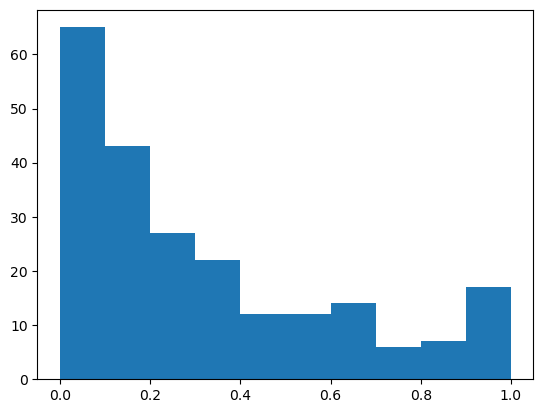

,chrom,pos,end,id,ciend,svlen,svtype,smeg.gt,smeg.dp,smeg.ad,...,smor.gt,smor.dp,smor.ad,smor.pl,smbre.af,smeg.af,smle-pzq-er.af,smle-pzq-es.af,smor.af,sv_id
5866,SM_V10_3,3155110,3158087,cuteSV.DEL.5233,"-1,0",-2979,DEL,0/0,15.0,"15,0",...,0/1,20.0,"13,7","252,11,510",0.952381,0.000000,0.0,0.107527,0.350000,DEL-SM_V10_3:3155110
5998,SM_V10_3,4588169,4593667,cuteSV.DEL.8017,"0,0",-5498,DEL,0/1,19.0,"14,5",...,0/0,28.5,"27.5,1","28,71,1168",0.000000,0.263158,1.0,0.977273,0.035088,DEL-SM_V10_3:4588169
5999,SM_V10_3,4600290,4600290,cuteSV.INS.6114,"0,0",595,INS,0/1,24.0,"20,4",...,0/0,20.0,"20,0","0,60,860",0.000000,0.166667,1.0,0.974026,0.000000,INS-SM_V10_3:4600290
6008,SM_V10_3,4638185,4641959,cuteSV.DEL.8034,"-1,0",-3774,DEL,0/1,21.0,"14,7",...,0/1,20.5,"18.5,2","63,38,772",0.000000,0.333333,1.0,1.000000,0.097561,DEL-SM_V10_3:4638185
6009,SM_V10_3,4653737,4653737,cuteSV.INS.6129,"0,0",111,INS,0/1,27.0,"21,6",...,0/1,20.0,"17,3","98,29,700",0.000000,0.222222,1.0,1.000000,0.150000,INS-SM_V10_3:4653737
6010,SM_V10_3,4658414,4658414,cuteSV.INS.6134,"0,4",525,INS,0/1,22.0,"19,3",...,0/1,24.0,"22,2","61,47,921",0.000000,0.136364,1.0,1.000000,0.083333,INS-SM_V10_3:4658414
6011,SM_V10_3,4661117,4661117,cuteSV.INS.6135,"0,3",263,INS,0/1,31.0,"24,7",...,0/1,35.0,"31,4","124,58,1286",0.000000,0.225806,1.0,0.960784,0.114286,INS-SM_V10_3:4661117
6013,SM_V10_3,4661875,4661875,cuteSV.INS.3238,"0,0",3641,INS,0/1,24.0,"18,6",...,0/0,26.5,"25,1.5","39,54,1049",0.000000,0.250000,1.0,0.880000,0.056604,INS-SM_V10_3:4661875
6014,SM_V10_3,4664947,4664947,cuteSV.INS.3240,"-7,3",173,INS,0/1,20.0,"13,7",...,0/0,24.0,"23,1","29,58,975",0.000000,0.350000,1.0,1.000000,0.041667,INS-SM_V10_3:4664947
6017,SM_V10_3,4668964,4668964,cuteSV.INS.6139,"-1,0",256,INS,0/0,15.0,"14,1",...,0/0,22.0,"21,1","29,52,889",0.000000,0.066667,1.0,0.957447,0.045455,INS-SM_V10_3:4668964


In [682]:
a = df.loc[ ((df["chrom"] == "SM_V10_3") &
         (df["pos"] >= 3079826) &
         (df["end"] <=4987169))].dropna()

j=a["smbre.af"]
k=a["smle-pzq-er.af"]
d=abs(j-k)

plt.hist(d)
plt.show()

er_i = a.loc[d>0.95].index
a.loc[d>0.95]

In [686]:
i_s = set(er_i).intersection(set(es_i))
a.loc[list(i_s)]

,chrom,pos,end,id,ciend,svlen,svtype,smeg.gt,smeg.dp,smeg.ad,...,smor.gt,smor.dp,smor.ad,smor.pl,smbre.af,smeg.af,smle-pzq-er.af,smle-pzq-es.af,smor.af,sv_id
6017,SM_V10_3,4668964,4668964,cuteSV.INS.6139,"-1,0",256,INS,0/0,15.0,"14,1",...,0/0,22.0,"21,1","29,52,889",0.0,0.066667,1.0,0.957447,0.045455,INS-SM_V10_3:4668964
6055,SM_V10_3,4850897,4851147,cuteSV.DEL.8091,"0,12",-249,DEL,0/1,16.0,"11,5",...,1/1,30.0,"0,30","1290,90,0",0.0,0.312500,1.0,1.000000,1.000000,DEL-SM_V10_3:4850897
6056,SM_V10_3,4851155,4851155,cuteSV.INS.4263,"0,0",1342,INS,0/1,16.0,"6,10",...,0/0,30.0,"30,0","0,90,1290",1.0,0.625000,0.0,0.000000,0.000000,INS-SM_V10_3:4851155
6027,SM_V10_3,4701408,4701408,cuteSV.INS.6153,"0,5",209,INS,0/1,26.0,"18,8",...,1/1,20.0,"0,20","860,60,0",0.0,0.307692,1.0,1.000000,1.000000,INS-SM_V10_3:4701408
5998,SM_V10_3,4588169,4593667,cuteSV.DEL.8017,"0,0",-5498,DEL,0/1,19.0,"14,5",...,0/0,28.5,"27.5,1","28,71,1168",0.0,0.263158,1.0,0.977273,0.035088,DEL-SM_V10_3:4588169
5999,SM_V10_3,4600290,4600290,cuteSV.INS.6114,"0,0",595,INS,0/1,24.0,"20,4",...,0/0,20.0,"20,0","0,60,860",0.0,0.166667,1.0,0.974026,0.000000,INS-SM_V10_3:4600290
6030,SM_V10_3,4706397,4706397,cuteSV.INS.6155,"-1,0",653,INS,0/1,18.5,"16,2.5",...,1/1,10.0,"0,10","430,30,0",0.0,0.135135,1.0,1.000000,1.000000,INS-SM_V10_3:4706397
6008,SM_V10_3,4638185,4641959,cuteSV.DEL.8034,"-1,0",-3774,DEL,0/1,21.0,"14,7",...,0/1,20.5,"18.5,2","63,38,772",0.0,0.333333,1.0,1.000000,0.097561,DEL-SM_V10_3:4638185
6009,SM_V10_3,4653737,4653737,cuteSV.INS.6129,"0,0",111,INS,0/1,27.0,"21,6",...,0/1,20.0,"17,3","98,29,700",0.0,0.222222,1.0,1.000000,0.150000,INS-SM_V10_3:4653737
6010,SM_V10_3,4658414,4658414,cuteSV.INS.6134,"0,4",525,INS,0/1,22.0,"19,3",...,0/1,24.0,"22,2","61,47,921",0.0,0.136364,1.0,1.000000,0.083333,INS-SM_V10_3:4658414


In [625]:
Path("{}/results/sv_type_counts_piechart".format(proj_dir)).mkdir(
    parents=True, exist_ok=True
)
os.chdir("{}/results/sv_type_counts_piechart".format(proj_dir))

In [43]:
cov_thresh = 8

filt_df = pd.read_csv(
    f"{proj_dir}/results/collapse_svs/sv_cat_afs_dp_ge_{cov_thresh}.csv",
    sep=",",
    header=0,
)
filt_df

,CHROM,POS,ID,REF,ALT,SVTYPE,SVLEN,smor.MAF,smle_pzq_es.MAF,smle_pzq_er.MAF,smbre.MAF,smeg.MAF,smor.COV,smle_pzq_es.COV,smle_pzq_er.COV,smbre.COV,smeg.COV
0,SM_V10_1,108036,cuteSV.INS.4,C,['CATTATTATTATTATTATTACTACTATTATTATTACTATT'],INS,39.0,1.0000,0.9429,0.8889,1.0000,0.9565,25,70,18,25,23
1,SM_V10_1,156118,cuteSV.DEL.7,ATGTTATCTTTGGCAGCCTATTTAAACATCTGGGCTACCTGTTCCT...,['A'],DEL,-401.0,0.3500,0.1587,0.3846,0.8750,0.2800,20,63,13,8,25
2,SM_V10_1,214273,cuteSV.INS.8,T,['TGATGATGATGATAGATATTGATGATGATGATGATGATGATGAT...,INS,51.0,0.1304,0.6667,0.9333,0.8696,0.3125,23,36,15,23,16
3,SM_V10_1,258698,cuteSV.INS.9,A,['ACTCGGGAATAACATTAGGATCACTTCAATTTTTTTAATAATTT...,INS,4470.0,0.2778,0.1897,0.1429,0.0930,0.3125,18,58,14,43,16
4,SM_V10_1,264300,cuteSV.INS.10,C,['CCTGGAAGCACTGGACGGCCGTTTCGTCCTATTGGCGGACCCCT...,INS,324.0,0.6579,0.2637,0.5455,0.6269,0.1522,38,91,22,67,46
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8096,SM_V10_Z,86357919,cuteSV.INS.4444,T,['TTGTTATGTCCCCTGGTGAATTATAAATGGTAACTCTGAGTCTA...,INS,604.0,0.3333,0.2222,0.1250,0.9545,0.3750,18,36,16,22,16
8097,SM_V10_Z,86361688,cuteSV.INS.4445,A,['AATCAGTAAGCGAGTAGTGATGGAAGTTTGGTTATTTTGGTACA...,INS,325.0,1.0000,1.0000,1.0000,1.0000,1.0000,17,47,26,24,20
8098,SM_V10_Z,86465601,cuteSV.DEL.5146,GTGCGCGTTCAAAAAGCGGATCACAAACTTTGTAGAAAAAT,['G'],DEL,-40.0,0.5000,0.2022,0.2292,0.0000,0.1667,38,89,48,29,54
8099,SM_V10_Z,86467302,cuteSV.INS.4446,G,['GAATTCTATATTTTTCAAGGGAGTTGAAATCATAAGTCAATCGA...,INS,229.0,0.5238,0.1860,0.0263,1.0000,0.1500,21,86,38,35,40


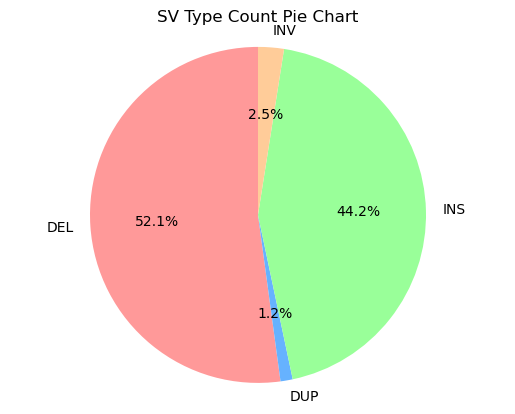

In [44]:
# sv_type_count = filt_df.loc[abs(filt_df["SVLEN"]) > 500].groupby("SVTYPE")["SVTYPE"].count().to_dict()

sv_type_count = filt_df.groupby("SVTYPE")["SVTYPE"].count().to_dict()

# Data for the pie chart
labels = list(sv_type_count.keys())
sizes = list(sv_type_count.values())
colors = ["#ff9999", "#66b2ff", "#99ff99", "#ffcc99"]

# Plotting the pie chart
plt.pie(sizes, labels=labels, colors=colors, autopct="%1.1f%%", startangle=90)
plt.axis("equal")  # Equal aspect ratio ensures the pie is drawn as a circle.
plt.title("SV Type Count Pie Chart")
plt.savefig("svtype_count_piechart.png", dpi=300)
plt.savefig("svtype_count_piechart.svg")
plt.show()